# Reverse MNIST

### What I've Learned
At first, it seemed that starting the weight matrices closer to 0 helped a lot. But I later realized that all it did was require more training.

In truth, it seemed to be a combination of a few key elements.
1. `FastLearn` does not work well for reconstructions. It does a good job for learning the discriminative task, but the (slow) `Learn` seems to find weight matrices that can do both.
2. Using a timestep in `Learn` that is too large (`dt`=0.01) was a problem. Once I started using `dt`=0.001, or even 0.005, I got much better reconstructions.
3. There was an issue with setting the correct combination of `alpha` and `beta` in the first couple layers. In particular, I needed to switch the bottom layer to feed-forward by adding `net.layer[0].SetFF()`.
4. There was also some strangeness when I didn't `Reset` the network state. The bottom layer seems to influence `FastLearn`. (`Learn` doesn't seem to have this problem.)
5. Weight decay and state decay don't seem to make much of a difference. Meh.
6. Removing $\sigma'$ from the $\varepsilon \rightarrow v$ projection actually makes the reconstructions a bit better.

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

def DrawDigit(x):
    plt.imshow(np.reshape(x.cpu(), (28,28)), cmap='gray', interpolation='nearest')
    plt.axis('off');

## Load MNIST DATA

In [330]:
train, validate, test = mnist_loader.load_data_wrapper()
train = [train[0], train[1]]
test = [test[0], test[1]]

In [591]:
howmany = 10000 #1000 #50
startind = 2857
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][startind:startind+howmany]).float().to(device), torch.tensor(train[1][startind:startind+howmany]).float().to(device)]
test = [torch.tensor(test[0][startind:startind+howmany]).float().to(device), torch.tensor(test[1][startind:startind+howmany]).float().to(device)]

In [2]:
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device)]
test = [torch.tensor(test[0]).float().to(device), torch.tensor(test[1]).float().to(device)]

In [25]:
#Retrieve one of each digit
idx = []
for i in range (0, 10):
    while True:
        j = np.random.randint(0, howmany)
        if np.argmax(train[1][j].cpu()) == i:
            idx.append(j)
            break

images = train[0][idx]
classes = train[1][idx]

In [26]:
print(net_decay)

[<NeuralNetwork.NeuralNetwork object at 0x7f7f454841d0>, <NeuralNetwork.NeuralNetwork object at 0x7f7f45484f60>, <NeuralNetwork.NeuralNetwork object at 0x7f7f45498c88>, <NeuralNetwork.NeuralNetwork object at 0x7f7f45183860>, <NeuralNetwork.NeuralNetwork object at 0x7f7f451944e0>, <NeuralNetwork.NeuralNetwork object at 0x7f7f45194860>, <NeuralNetwork.NeuralNetwork object at 0x7f7f451a2da0>, <NeuralNetwork.NeuralNetwork object at 0x7f7f451aeac8>, <NeuralNetwork.NeuralNetwork object at 0x7f7f451b85f8>, <NeuralNetwork.NeuralNetwork object at 0x7f7f4514d278>, <NeuralNetwork.NeuralNetwork object at 0x7f7f4514df60>, <NeuralNetwork.NeuralNetwork object at 0x7f7f45159be0>]


/usr/local/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


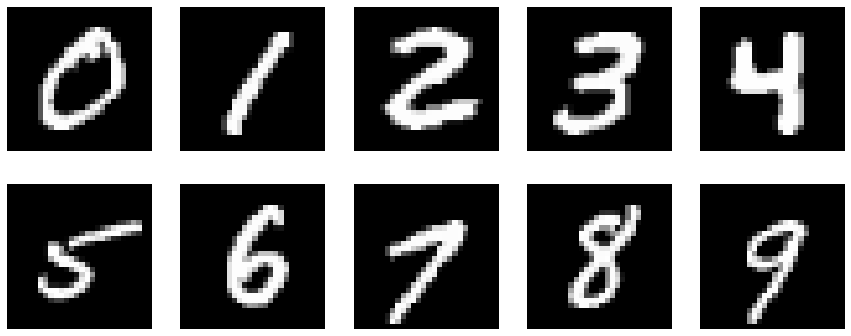

In [3]:
#      0  1   2  3   4   5   6   7   8   9
idx = [1, 3, 25, 7, 58,145, 62, 79, 41, 57]
plt.figure(figsize=[15,6])
for n,k in enumerate(idx):
    plt.subplot(2,5,n+1)
    DrawDigit(torch.tensor(train[0][k]))

In [ ]:
ten_images = train[0][idx]
ten_classes = train[1][idx]

In [ ]:
# Add noise if you want
n_epochs = 10
N = len(train[0])
noisy_train0 = []
noisy_train1 = []
for n in range(n_epochs):
    for x,t in zip(train[0], train[1]):
        noisy_train0.append(x+torch.normal(torch.zeros_like(x), 0.1))
        noisy_train1.append(t)
train[0] = torch.stack(noisy_train0).float().to(device)
train[1] = torch.stack(noisy_train1).float().to(device)

In [ ]:
# Make zero-mean if you want
n_epochs = 1
N = len(train[0])
noisy_train0 = []
noisy_train1 = []
for n in range(n_epochs):
    for x,t in zip(train[0], train[1]):
        noisy_train0.append(x - torch.mean(x))
        noisy_train1.append(t)
train[0] = torch.stack(noisy_train0).float().to(device)
train[1] = torch.stack(noisy_train1).float().to(device)

### Transform input a la Whittington & Bogcz

In [ ]:
def inv_logistic_raw(y):
    z = torch.log( y / (1.0 - y) )
    z[z>5.] = 5
    z[z<-5.] = -5.
    return z

def inv_logistic(dataset):
    for idx in range(len(dataset)):
        y = inv_logistic_raw(dataset[idx])
        dataset[idx] = y

In [ ]:
# Transform the input a la Whittington & Bogacz
train[1] = train[1]*0.94 + 0.03
test[1] = test[1]*0.94 + 0.03

In [ ]:
inv_logistic(train[0])
inv_logistic(test[0])

## Create Network

In [4]:
importlib.reload(NN)
importlib.reload(Layer);

In [5]:
# Deep Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))
#net.AddLayer(Layer.PELayer(n=200))
net.AddLayer(Layer.PELayer(n=600))
#net.AddLayer(Layer.PELayer(n=50))
net.AddLayer(Layer.TopPELayer(n=784))
af = 'identity'
sym = False
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)
#net.Connect(2, 3, act=af, symmetric=sym)
#net.Connect(3, 4, act=af, symmetric=sym)
net.SetTau(0.08)
net.learn_biases = False

identity
identity


In [ ]:
net0 = deepcopy(net)

In [ ]:
net1 = deepcopy(net)

## Train the Network

In [333]:
len(net_nodecay)

30

In [6]:
reinitialize = True
iters = 10
howmany = 1000

In [7]:
if reinitialize:
    epochs = 10
    T = 5.
    dt = 0.002
    batch_size = 40

    v_decay = []
    v_nodecay = []
    M0_decay = []
    M1_decay = []
    M0_nodecay = []
    M1_nodecay = []
    W0_decay = []
    W1_decay = []
    W0_nodecay = []
    W1_nodecay = []

    net_nodecay = []
    net_decay = []

    seed = 3856
    torch.manual_seed(seed)

for k in range(iters):
    net = NN.NeuralNetwork()
    net.AddLayer(Layer.InputPELayer(n=10))
    net.AddLayer(Layer.PELayer(n=600))
    net.AddLayer(Layer.TopPELayer(n=784))

    af = 'identity'
    sym = False
    net.Connect(0, 1, act=af, symmetric=sym)
    net.Connect(1, 2, act=af, symmetric=sym)
    net.SetTau(0.08)
    net.learning_tau = 0.8
    net.learn_biases = False

    print(net.connections[0].M)
    print(net.connections[1].W)

    #Select 1000 random images
    startind = np.random.randint(0, 48999)
    # startind = 3857
    
    # Make two copies
    net0 = deepcopy(net)
    net1 = deepcopy(net)

    net0.SetWeightDecay(0.)
    net0.SetvDecay(0.)
    net0.Learn(torch.tensor(train[1][startind:startind+howmany]).float().to(device), torch.tensor(train[0][startind:startind+howmany]).float().to(device), T=T, dt=dt, epochs=epochs, batch_size=batch_size)

    net1.SetWeightDecay(0.04)
    net1.SetvDecay(0.04)
    net1.Learn(torch.tensor(train[1][startind:startind+howmany]).float().to(device), torch.tensor(train[0][startind:startind+howmany]).float().to(device), T=T, dt=dt, epochs=epochs, batch_size=batch_size)
    
    '''
    net0.Allocate(torch.tensor(train[1][startind:startind+howmany]).float().to(device))
    net0.Reset()
    net0.layers[0].SetFF()
    net0.layers[-1].SetFF()
    y0 = net0.Predict(T, torch.tensor(train[1][startind:startind+howmany]).float().to(device), dt=0.001)
    
    net1.Allocate(torch.tensor(train[1][startind:startind+howmany]).float().to(device))
    net1.Reset()
    net1.layers[0].SetFF()
    net1.layers[-1].SetFF()
    net1.SetvDecay(0.01)
    y1 = net1.Predict(T, torch.tensor(train[1][startind:startind+howmany]).float().to(device), dt=0.001)
    '''
    net_nodecay.append(deepcopy(net0))
    net_decay.append(deepcopy(net1))
    '''
    v_nodecay.append(net0.layers[1].v.cpu().numpy())
    v_decay.append(net1.layers[1].v.cpu().numpy())

    M0_nodecay.append(net0.connections[0].M)
    M0_decay.append(net1.connections[0].M)
    M1_nodecay.append(net0.connections[1].M)
    M1_decay.append(net1.connections[1].M)
    
    W0_nodecay.append(net0.connections[0].W)
    W0_decay.append(net1.connections[0].W)
    W1_nodecay.append(net0.connections[1].W)
    W1_decay.append(net1.connections[1].W)
    '''

identity
identity
tensor([[ 0.1107,  0.0988, -0.1565,  ...,  0.1617,  0.3341,  0.0603],
        [ 0.1604, -0.1837, -0.0379,  ..., -0.1538, -0.1396,  0.0794],
        [-0.2592, -0.3695,  0.3300,  ..., -0.1903,  0.1667,  0.0773],
        ...,
        [-0.0613,  0.2033, -0.1822,  ...,  0.1891,  0.0755, -0.0111],
        [ 0.1969, -0.1180,  0.0674,  ..., -0.2246,  0.0433,  0.1421],
        [ 0.1698,  0.0669, -0.0794,  ...,  0.0582, -0.1852,  0.1420]],
       device='cuda:0')
tensor([[-2.6129e-02,  8.7183e-03, -1.9041e-02,  ..., -1.0146e-02,
          1.7365e-02,  5.4073e-03],
        [ 1.6999e-02,  1.7980e-02,  9.4303e-03,  ..., -2.4861e-02,
          2.0259e-02,  3.2893e-03],
        [-3.6896e-02,  2.1478e-02,  1.1055e-02,  ..., -5.6117e-03,
          1.9311e-02,  8.3431e-03],
        ...,
        [ 4.5338e-03,  1.6307e-02,  2.1628e-02,  ..., -1.7259e-02,
          1.3605e-03,  1.3378e-02],
        [ 1.7181e-02,  3.8115e-02,  2.0820e-02,  ...,  1.3916e-02,
         -4.9920e-03, -1.7468e-0

/usr/local/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


FloatProgress(value=0.0, max=10000.0)

KeyboardInterrupt: 

In [588]:
net0 = net_nodecay[-16]
net1 = net_decay[-16]

In [ ]:
net0.Allocate(howmany)

# FAST METHOD: Training Accuracy
correct = 0
z = net0.BackprojectExpectation(train[0])
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(train[1].cpu(), 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('no decay net train set accuracy: {rate}'.format(rate=(correct / len(train[0]))))

In [500]:
net0.Allocate(test[0])

# FAST METHOD: Training Accuracy
correct = 0
z = net0.BackprojectExpectation(torch.tensor(test[0]).float().to(device))
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(torch.tensor(test[1]).float(), 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('no decay net test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

no decay net test set accuracy: 0.5776


In [162]:
net1.Allocate(howmany)

# FAST METHOD: Training Accuracy
correct = 0
z = net1.BackprojectExpectation(train[0])
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(train[1].cpu(), 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('decay net train set accuracy: {rate}'.format(rate=(correct / len(train[0]))))

asymmetric weights train set accuracy: 0.714


In [590]:
net1.Allocate(test[0])

# FAST METHOD: Training Accuracy
correct = 0
z = net1.BackprojectExpectation(torch.tensor(test[0]).float().to(device))
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(torch.tensor(test[1]).float().cpu(), 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('decay net test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

decay net test set accuracy: 0.7032059358812823


/usr/local/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


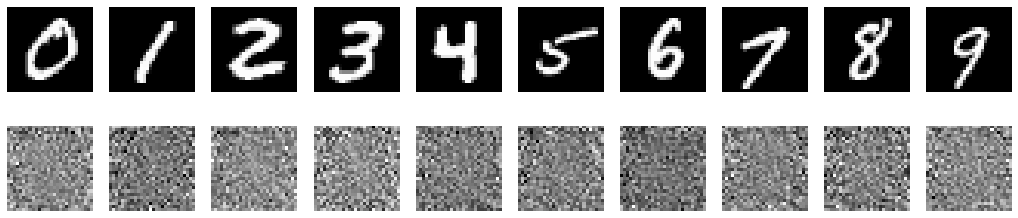

In [569]:
net0.Allocate(classes)

net0.Reset()
# Continuous-time version
net0.SetvDecay(0.0)
net0.layers[0].SetFF()
net0.layers[-1].SetFF()

z = net0.Predict(60., classes, dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(torch.tensor(train[0][idx[n]]))
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [570]:
generated_input = z.clone().detach()

In [571]:
for i in range(0, len(generated_input)):
    generated_input[i] = torch.clamp(torch.sign(generated_input[i]-0.0), min=0.)

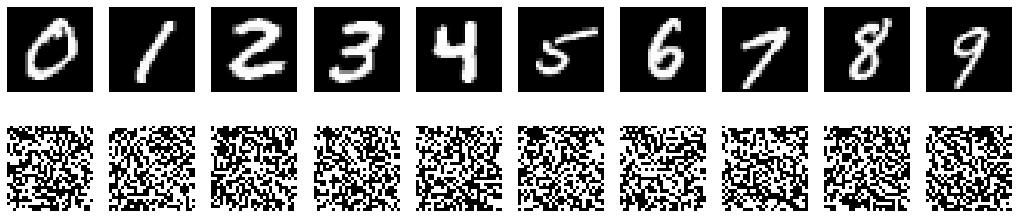

In [572]:
plt.figure(figsize=[18,4])
for n,zz in enumerate(generated_input):
    plt.subplot(2,10,n+1); DrawDigit(torch.tensor(train[0][idx[n]]))
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [573]:
#Does generated input yield 1-hot?

net0.Reset()
net0.SetvDecay(0.0)
net0.layers[0].SetFB()
net0.layers[-1].SetBidirectional()
y = net0.Generate(60., generated_input, dt=0.002)

In [574]:
np.set_printoptions(suppress=True)

print(np.asarray(y.cpu()))

[[12.144628    1.517791    0.04089646  1.3459826  -1.3210748  -0.33417937
  -0.09849299  0.88387805 -2.061415    0.5189488 ]
 [ 0.30076844 12.957329    0.74502563  2.557233   -0.8641266   0.2628624
  -0.0234322   0.8477755  -2.3308058  -0.6077049 ]
 [-1.5760046   1.3654481  13.110952    1.3035358  -1.4581035  -0.91137874
   1.3119749   1.7829665  -1.1618044  -1.6198927 ]
 [ 0.27710176  2.0135396  -0.49496147 15.3342285  -0.51182544  1.23675
   1.8142481   0.21497236 -1.7647029  -1.7610698 ]
 [-1.146873    2.2323563  -2.7050023   1.845011   13.2908945   0.21549967
   1.7401481   2.334761   -1.257766   -1.1830934 ]
 [ 0.74750304  0.9381251  -0.6177656   0.9190413   0.7780321  12.698705
   1.3402302   0.85872185 -1.5381223  -0.48167223]
 [ 0.6936335   1.3570889  -1.449226   -0.37182492 -1.7169511  -0.59007555
  13.152426    1.151251   -1.2503422  -0.8155915 ]
 [-0.6176389   1.9175403  -1.1980485   2.1502588   0.22820184 -0.427009
   2.4204395  13.909806   -1.8133634   0.43880346]
 [ 0.279

In [116]:
print(net0.layers[1].v)

tensor([[-0.0673,  0.0120, -0.0570,  ...,  0.0413,  0.0439,  0.0266],
        [ 0.0411,  0.0197,  0.0291,  ..., -0.0050,  0.0312, -0.0215],
        [-0.0263, -0.0013,  0.0515,  ..., -0.0929,  0.1048, -0.0606],
        ...,
        [-0.0107,  0.0222,  0.0242,  ..., -0.0526,  0.0333, -0.0257],
        [-0.0440, -0.0306,  0.0541,  ..., -0.0370,  0.0270, -0.0616],
        [ 0.0132,  0.0276,  0.0194,  ..., -0.0241, -0.0146, -0.0878]],
       device='cuda:0')


In [117]:
print(net0.layers[2].v)

tensor([[ 0.0086,  0.0038,  0.0107,  ...,  0.0128,  0.0122,  0.0187],
        [ 0.0131, -0.0034,  0.0016,  ...,  0.0086, -0.0138,  0.0109],
        [-0.0032, -0.0034,  0.0062,  ...,  0.0318, -0.0045,  0.0110],
        ...,
        [-0.0175,  0.0024,  0.0004,  ...,  0.0174, -0.0218,  0.0116],
        [ 0.0037, -0.0238,  0.0175,  ...,  0.0274, -0.0197,  0.0108],
        [-0.0203,  0.0102,  0.0020,  ...,  0.0291, -0.0141,  0.0003]],
       device='cuda:0')


In [177]:
np.amax(np.abs(np.asarray(net0.connections[1].M.cpu())))

0.60336787

In [178]:
np.mean(np.abs(np.asarray(net0.connections[1].M.cpu())))

0.12998149

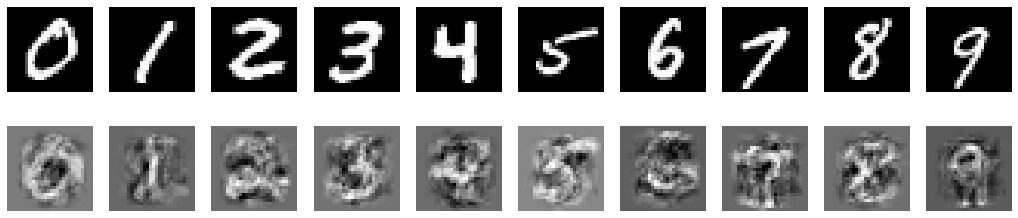

In [556]:
net1.Allocate(classes)

net1.Reset()
# Continuous-time version
net1.SetvDecay(0.04)
net1.layers[0].SetFF()
net1.layers[-1].SetFF()
z = net1.Predict(60., classes, dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(torch.tensor(train[0][idx[n]]))
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [565]:
generated_input = z.clone().detach()

In [566]:
for i in range(0, len(generated_input)):
    generated_input[i] = torch.clamp(torch.sign(generated_input[i]-0.05), min=0.)

In [567]:
print(generated_input)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


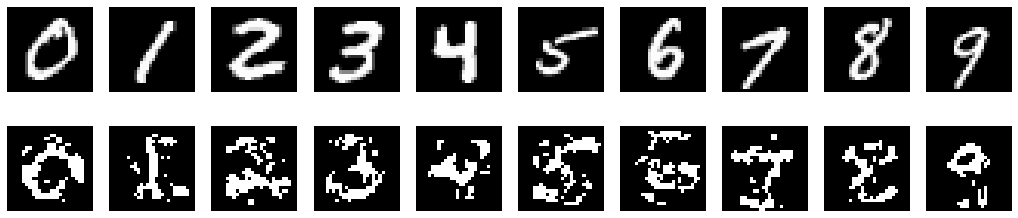

In [568]:
plt.figure(figsize=[18,4])
for n,zz in enumerate(generated_input):
    plt.subplot(2,10,n+1); DrawDigit(torch.tensor(train[0][idx[n]]))
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [547]:
#Does generated input yield 1-hot?

net1.Reset()
net1.SetvDecay(0.0)
net1.layers[0].SetFB()
net1.layers[-1].SetBidirectional()
y = net1.Generate(60., generated_input, dt=0.002)

In [548]:
np.set_printoptions(suppress=True)
print(np.asarray(y.cpu()))

[[ 1.1707727   0.19458652  0.11973601 -0.14919303  0.02341728 -0.01569443
  -0.00655782 -0.04544637 -0.02709538  0.0443769 ]
 [ 0.19298252  1.5768821  -0.05461216 -0.14278659 -0.13691062  0.15110117
   0.0746555   0.10894188 -0.14425993 -0.07899432]
 [-0.06059317 -0.15878858  2.1183643  -0.18398678 -0.13206612  0.1939988
  -0.08662719  0.11270483 -0.05123981 -0.19753338]
 [-0.04634582 -0.23553814  0.12737006  1.9789227   0.01189099 -0.03956663
   0.2036345   0.03007067 -0.36101684 -0.14304988]
 [ 0.13809538 -0.00672642 -0.05457247  0.11475939  1.8330184   0.03284231
   0.03871753 -0.13620858 -0.00118861 -0.33854324]
 [-0.06748756 -0.05293705  0.35296443 -0.20746443 -0.1609513   1.4295412
   0.11840006  0.24382494 -0.06960186 -0.21599956]
 [-0.1138237  -0.20835586  0.00825048  0.20604402 -0.1343228   0.20581925
   1.1591436   0.18419246 -0.03431118  0.02176053]
 [-0.01149999  0.05448647  0.01217686 -0.08053599 -0.20102383  0.08480702
   0.1846407   1.3813289  -0.06288745 -0.28068104]
 [

In [575]:
decay_lam = 0.04

predicted_class_nodecay = []
predicted_class_decay = []

fp = FloatProgress(min=0,max=(len(net_decay)-20)*2)
display(fp)

for i in range(20, len(net_decay)):
    net0 = net_nodecay[i]
    net1 = net_decay[i]
    
    net0.Allocate(classes)
    net0.Reset()
    net0.SetvDecay(decay_lam)
    net0.layers[0].SetFF()
    net0.layers[-1].SetFF()
    z = net0.Predict(60., classes, dt=0.002)
    
    generated_input = z.clone().detach()
    
    for i in range(0, len(generated_input)):
        generated_input[i] = torch.clamp(torch.sign(generated_input[i]-0.05), min=0.)
    
    net0.Reset()
    net0.SetvDecay(0.0)
    net0.layers[0].SetFB()
    net0.layers[-1].SetBidirectional()
    y = net0.Generate(60., generated_input, dt=0.002)

    predicted_class_nodecay.append(y.cpu().numpy())
    #print(np.asarray(y.cpu()))

    fp.value += 1
    
    net1.Allocate(classes)
    net1.Reset()
    net1.SetvDecay(decay_lam)
    net1.layers[0].SetFF()
    net1.layers[-1].SetFF()
    z = net1.Predict(60., classes, dt=0.002)
    
    generated_input = z.clone().detach()
    
    for i in range(0, len(generated_input)):
        generated_input[i] = torch.clamp(torch.sign(generated_input[i]-0.05), min=0.)
    
    net1.Reset()
    net1.SetvDecay(0.0)
    net1.layers[0].SetFB()
    net1.layers[-1].SetBidirectional()
    y = net1.Generate(60., generated_input, dt=0.002)

    predicted_class_decay.append(y.cpu().numpy())
    #print(np.asarray(y.cpu()))
    
    fp.value += 1

FloatProgress(value=0.0, max=20.0)

In [582]:
# Find average difference between predicted class vector and true one-hot class vector
discrepency = []
for i in range(0, len(predicted_class_decay)):
    discrepency.append(abs(predicted_class_decay[i] - classes.cpu().numpy()))
print(np.mean(discrepency, axis=0))

[[0.39752132 0.09687611 0.10322328 0.11015103 0.07705571 0.18555193
  0.06689421 0.04405562 0.06936111 0.07566467]
 [0.0643641  0.4775474  0.04319584 0.11196236 0.08267391 0.06692277
  0.07089064 0.08637288 0.1701418  0.0832682 ]
 [0.09952112 0.27030492 0.9739151  0.12270258 0.10745194 0.09039481
  0.16361001 0.12787211 0.15578395 0.11361678]
 [0.1072667  0.22311711 0.09696508 0.7139276  0.0436721  0.19989401
  0.099962   0.0744959  0.1451968  0.08465795]
 [0.06869685 0.03893119 0.05746602 0.0668606  0.419374   0.08231451
  0.09226159 0.08535311 0.07220868 0.17822185]
 [0.12978055 0.12213878 0.0815609  0.14350887 0.06812968 0.80684674
  0.10617627 0.08203303 0.14156279 0.1655229 ]
 [0.05636049 0.12743874 0.23240507 0.10841034 0.15648742 0.138679
  0.8298451  0.0687743  0.12547663 0.20846102]
 [0.0699895  0.10829946 0.07030343 0.06285019 0.16003537 0.07627474
  0.09229645 0.78176135 0.07592053 0.22558263]
 [0.07890353 0.18718722 0.12646872 0.14840315 0.11022884 0.14732665
  0.1224463  0

In [577]:
# Find average difference between predicted class vector and true one-hot class vector
discrepency = []
for i in range(0, len(predicted_class_nodecay)):
    discrepency.append(abs(predicted_class_nodecay[i] - classes.cpu().numpy()))
print(np.mean(discrepency, axis=0))

[[0.91053694 0.04698374 0.07113642 0.00439611 0.00273884 0.02861146
  0.01522165 0.04516322 0.02560209 0.07420145]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00584791 0.00485511 0.97345334 0.02091739 0.02418297 0.01530936
  0.0309588  0.02276618 0.01253106 0.03202127]
 [0.00277311 0.00233188 0.01405596 0.9566051  0.0046416  0.0073237
  0.02102245 0.02536854 0.00615725 0.00326709]
 [0.00612921 0.00650061 0.00088649 0.01002289 0.9527582  0.0003871
  0.00058177 0.0144446  0.02201454 0.02801635]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.00333136 0.01708095 0.00875981 0.01938296 0.03745334 0.02685853
  0.9243971  0.01657225 0.01674213 0.02883088]
 [0.01381644 0.00204575 0.00352551 0.03724609 0.0336757  0.0098099
  0.00739751 0.93935096 0.00170435 0.00957377]
 [0.01355301 0.00300457 0.01218228 0.00248094 0.00434705 0.01232327
  0.01340215 0.01394839 0.96931

In [583]:
print(discrepency)

[array([[0.32662332, 0.02248265, 0.1733524 , 0.23617464, 0.09008339,
        0.04574157, 0.12166097, 0.08827677, 0.18336321, 0.24300961],
       [0.12168844, 0.16435671, 0.06526895, 0.02509003, 0.0746593 ,
        0.07682572, 0.01099752, 0.04852418, 0.1850978 , 0.00268877],
       [0.0142067 , 0.141917  , 1.7528498 , 0.02913113, 0.1295668 ,
        0.03779111, 0.20481363, 0.30509374, 0.34053957, 0.13494281],
       [0.16069706, 0.3201047 , 0.01634843, 1.2103877 , 0.04563405,
        0.20615612, 0.00424068, 0.07133592, 0.18605371, 0.05133886],
       [0.06473038, 0.006479  , 0.06332295, 0.07889978, 0.35599852,
        0.01111832, 0.12316037, 0.03347607, 0.09863665, 0.09841299],
       [0.0198105 , 0.0295782 , 0.00740677, 0.08303393, 0.05591659,
        0.63098204, 0.2251182 , 0.11412997, 0.1343277 , 0.16011257],
       [0.03989429, 0.1021608 , 0.03809247, 0.16002193, 0.22197336,
        0.04318254, 0.7586607 , 0.05086388, 0.19214264, 0.07215949],
       [0.03678496, 0.14348114, 0.173797

In [586]:
#no_vdecay_predicted_class_d = deepcopy(predicted_class_decay)
#no_vdecay_predicted_class_nd = deepcopy(predicted_class_nodecay)
np.mean(np.asarray(predicted_class_nodecay), axis=0) - classes.cpu().numpy()


array([[-0.91053694, -0.01583961,  0.07113642, -0.0017084 , -0.00086796,
        -0.01097219, -0.01522165,  0.02467523, -0.02560209,  0.07420145],
       [ 0.        , -1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00584791,  0.00485511, -0.9734533 , -0.02091739,  0.02418297,
        -0.01530936,  0.0309588 ,  0.02276618, -0.01253106, -0.03202127],
       [ 0.00277311, -0.00233188, -0.01405596, -0.956605  ,  0.0046416 ,
        -0.0073237 , -0.02102245,  0.02536854,  0.00615725, -0.00326709],
       [-0.00612921, -0.00650061, -0.00088649,  0.01002289, -0.9527582 ,
         0.0003871 ,  0.00058177,  0.0144446 ,  0.02201454, -0.02801635],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00333136, -0.01708095,  0.00184308, -0.01938296,  0.01904003,
        -0.02685853, -0.92439705, -0.00943894

In [579]:
print(np.mean(np.asarray(no_vdecay_predicted_class_d), axis=0))
print(np.mean(np.asarray(no_vdecay_predicted_class_nd), axis=0))

[[ 0.87312937 -0.03229418 -0.06725773 -0.07066289 -0.05008198 -0.07301005
  -0.06540104 -0.05282994 -0.07244266 -0.05764041]
 [-0.03171719  0.96543515 -0.04107493 -0.04424087 -0.02984822 -0.0359453
  -0.03569749 -0.03095099 -0.05366727 -0.03392107]
 [-0.06618903 -0.04123126  0.92279255 -0.06654824 -0.05299753 -0.05601371
  -0.06438565 -0.04841382 -0.07427909 -0.05460664]
 [-0.07000892 -0.04486171 -0.06744539  0.8976863  -0.04719768 -0.06697999
  -0.05649225 -0.05348504 -0.08360013 -0.05823741]
 [-0.05055999 -0.03100058 -0.05450328 -0.04828428  0.92556226 -0.04749285
  -0.05927714 -0.05373422 -0.06252543 -0.0631261 ]
 [-0.0732279  -0.03657531 -0.05657334 -0.06702505 -0.04654986  0.9197341
  -0.05214997 -0.04847496 -0.07315949 -0.05447029]
 [-0.06434682 -0.03570681 -0.06425521 -0.0556231  -0.05766344 -0.051472
   0.9273842  -0.04458539 -0.06718714 -0.05532634]
 [-0.05209518 -0.03124915 -0.04849131 -0.05292208 -0.05229978 -0.04811476
  -0.04480344  0.9401034  -0.06199567 -0.05736591]
 [-0

In [584]:
mean_predicted_classes_decay = np.mean(np.asarray(predicted_class_decay), axis=0)
mean_predicted_class_decay = 0
for i in range(0, 10):
    mean_predicted_class_decay += mean_predicted_classes_decay[i][i]
mean_predicted_class_decay *= 0.1
print(mean_predicted_class_decay)

1.6750505447387696


In [585]:
mean_predicted_classes_nodecay = np.mean(np.asarray(predicted_class_nodecay), axis=0)
mean_predicted_class_nodecay = 0
for i in range(0, 10):
    mean_predicted_class_nodecay += mean_predicted_classes_nodecay[i][i]
mean_predicted_class_nodecay *= 0.1
print(mean_predicted_class_nodecay)

0.0373587004840374


In [473]:
no_vdecay_mean_predicted_classes_decay = np.mean(np.asarray(no_vdecay_predicted_class_d), axis=0)
no_vdecay_mean_predicted_class_decay = 0
for i in range(0, 10):
    no_vdecay_mean_predicted_class_decay += no_vdecay_mean_predicted_classes_decay[i][i]
no_vdecay_mean_predicted_class_decay *= 0.1
print(no_vdecay_mean_predicted_class_decay)

0.9175650835037232


In [474]:
no_vdecay_mean_predicted_classes_nodecay = np.mean(np.asarray(no_vdecay_predicted_class_nd), axis=0)
no_vdecay_mean_predicted_class_nodecay = 0
for i in range(0, 10):
    no_vdecay_mean_predicted_class_nodecay += no_vdecay_mean_predicted_classes_nodecay[i][i]
no_vdecay_mean_predicted_class_nodecay *= 0.1


print(no_vdecay_mean_predicted_class_nodecay)

0.9742269396781922


In [256]:
np.amax(np.abs(np.asarray(generated_input.cpu())))

0.0

# Investigate cosine similarity of generated image to mean of MNIST digit

In [656]:
print(len(net_d))

20


In [659]:
net_d = net_decay
net_nd = net_nodecay

print(net_nd[0].connections[0].activation_function)

tanh


0.55248314
0.6081178
0.42308027
0.37747538
0.40253806
0.42565954
0.47147003
0.55428576
0.3599504
0.3322442
0.51755697
0.5661137
0.40806115
0.41615987
0.49068874
0.22717263
0.44148242
0.47451866
0.36758775
0.34480095
0.50334793
0.57536376
0.45825145
0.4186687
0.44777954
0.2893652
0.4648431
0.47784528
0.37758836
0.26577875
0.44627512
0.54335177
0.47427365
0.48003337
0.37880704
0.38021544
0.50425786
0.4807784
0.30916116
0.3135302
0.5376041
0.57319033
0.3822816
0.42313096
0.38855267
0.21896692
0.48795116
0.48894113
0.351991
0.4342935
0.41321242
0.56022644
0.40871364
0.40811026
0.46569112
0.2604026
0.46721408
0.47766024
0.3059461
0.4046151
0.5135099
0.58486766
0.48763922
0.4541234
0.43520257
0.36151978
0.3927556
0.4989837
0.3271085
0.3088471
0.50611585
0.5600509
0.45157853
0.43961284
0.4795121
0.27063376
0.51715434
0.53833973
0.35753086
0.29140872
0.51685727
0.43447593
0.45287764
0.350584
0.3522697
0.3368091
0.46433944
0.4196173
0.33279783
0.3667217
0.4190221
0.57488495
0.43897834
0.4036481

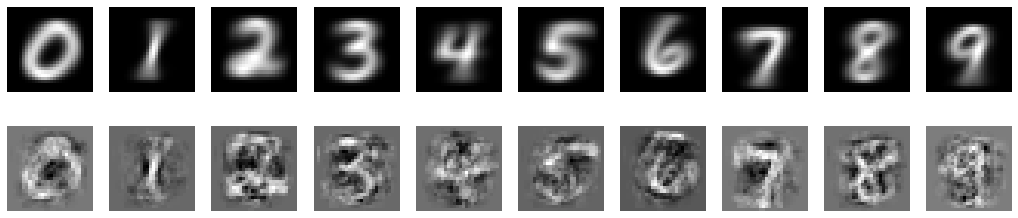

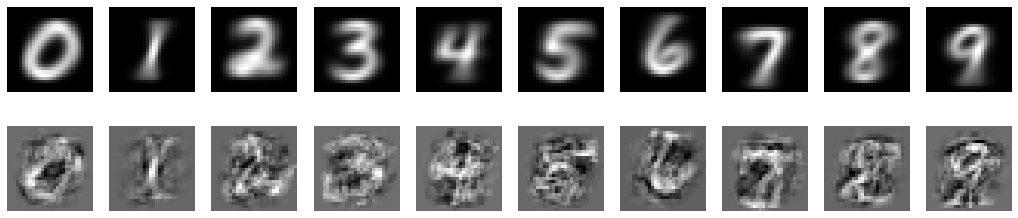

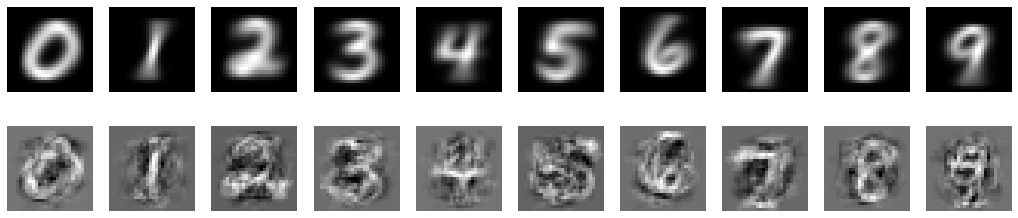

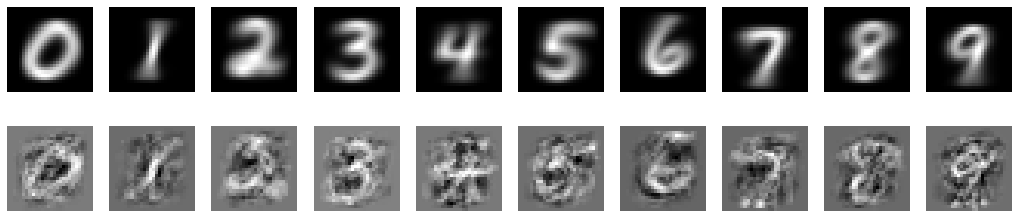

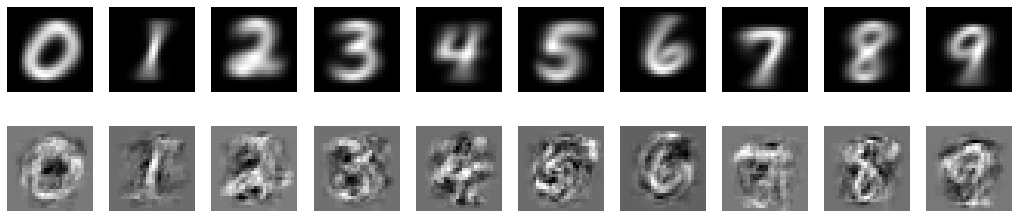

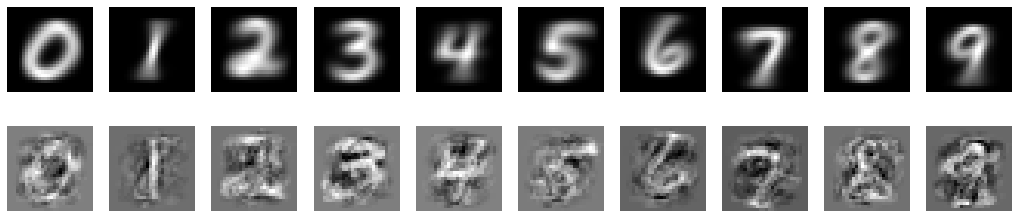

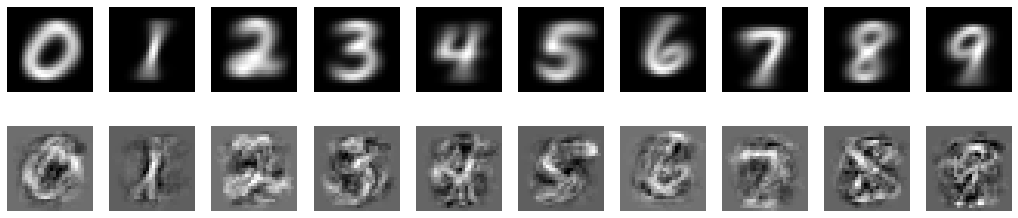

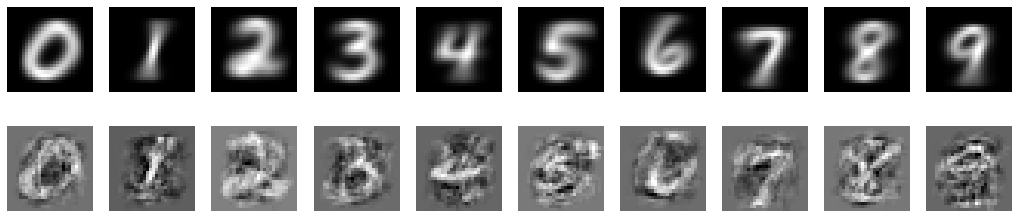

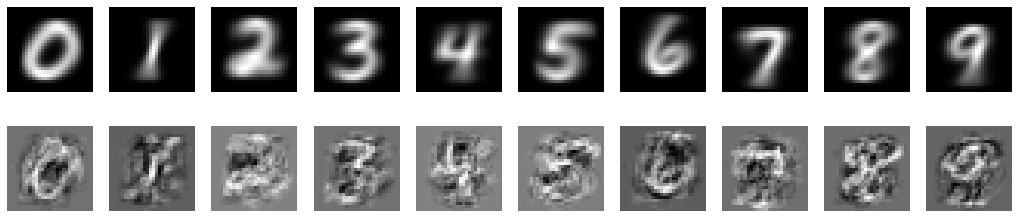

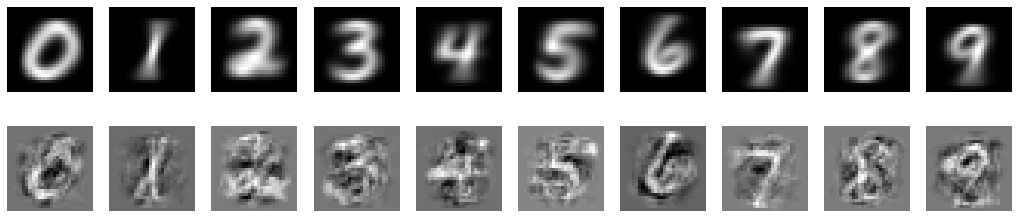

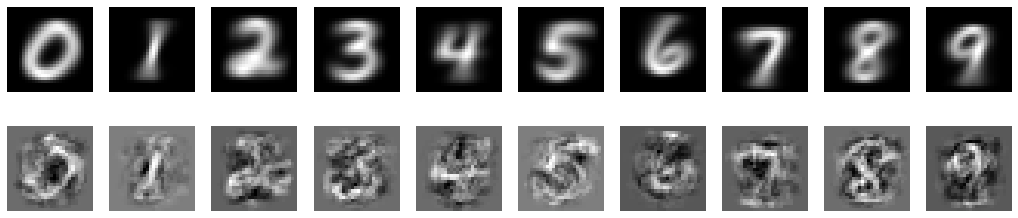

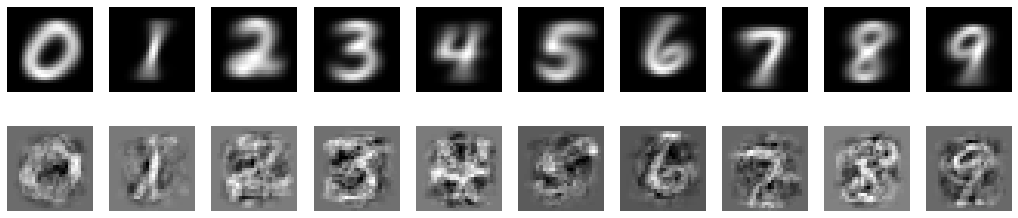

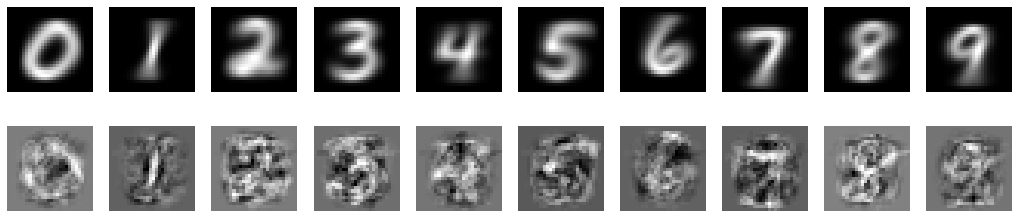

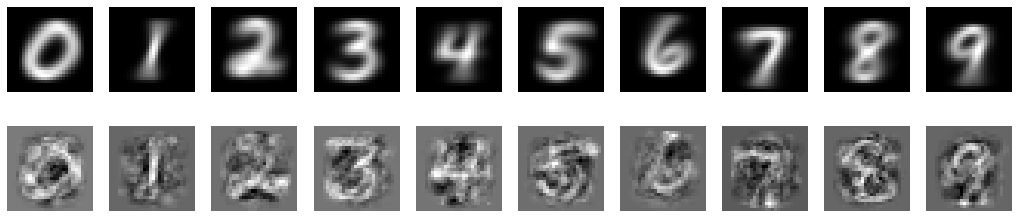

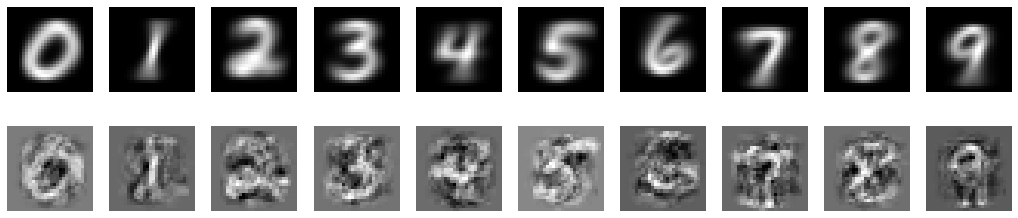

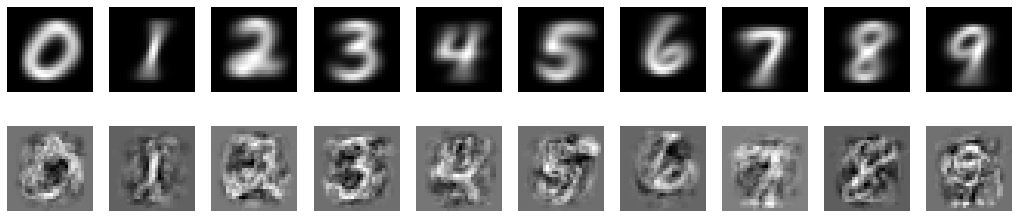

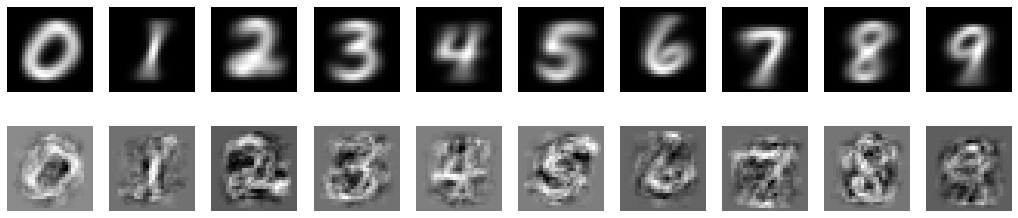

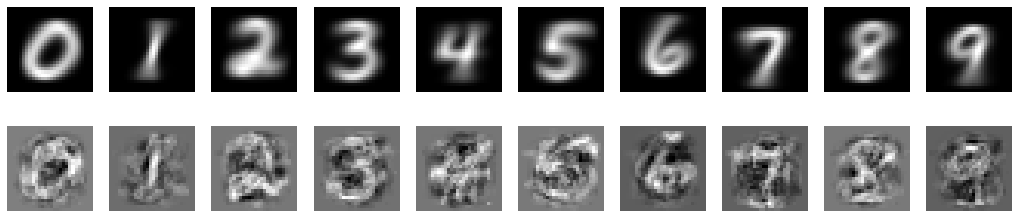

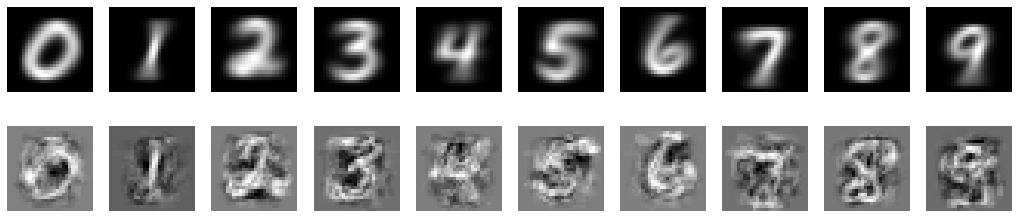

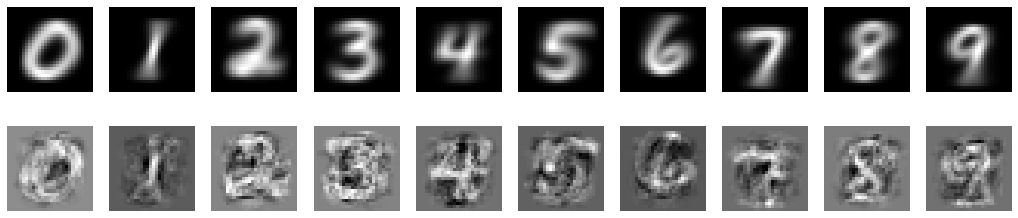

In [622]:
cos_similarities_d = []
for i in range(0, 10):
    cos_similarities_d.append([])
    
means_of_class_c = []

for net1 in net_d:
    net1.Allocate(classes)
    net1.Reset()
    net1.SetvDecay(0.04)
    net1.layers[0].SetFF()
    net1.layers[-1].SetFF()
    z = net1.Predict(60., classes, dt=0.002)

    plt.figure(figsize=[18,4])
    for c in range(10):
        images_of_class_c = train[0][train[1][:,c]==1]
        means_of_class_c.append(torch.mean(images_of_class_c, dim=0).cpu())

        generated = z[c].cpu()
        cos_similarities_d[c].append(np.dot(generated, means_of_class_c[-1]) / (np.linalg.norm(generated)*np.linalg.norm(means_of_class_c[-1])))
        print(cos_similarities_d[c][-1])

        plt.subplot(2,10,c+1); DrawDigit(means_of_class_c[-1])
        plt.subplot(2,10,c+11); DrawDigit(generated)

In [667]:
mean_cos_sim = 0
for c in range(0, 10):
    for d in range(0, 20):
        mean_cos_sim += cos_similarities_d[c][d]
mean_cos_sim /= 200.0
print(mean_cos_sim)

0.4273700460791588


In [668]:
max_cos_sim = 0
for c in range(0, 10):
    for d in range(0, 20):
        if cos_similarities_d[c][d] > max_cos_sim:
            max_cos_sim = cos_similarities_d[c][d]
print(max_cos_sim)

0.6081178


0.020596512
0.06581186
0.032020785
0.039978996
0.012840314
0.022845805
0.03553833
-0.0035811027
0.057199676
-0.0034794032
0.014658304
0.018047865
-0.008877627
-0.03539855
0.009866368
-0.007871465
-0.017633323
0.0024084228
-0.0038998195
-0.009163301
0.0024441103
0.049852904
0.004524895
0.026028553
0.025497762
0.03225907
0.016049856
-0.010109753
0.02880797
-0.024835149
0.01419773
-0.026231589
-0.011942468
-0.019352179
0.0019231157
0.016631769
-0.0058322796
-0.0023416015
-0.0008573473
-0.029232977
0.040039346
0.014408564
0.013876009
0.0031005377
0.009317769
-0.014473955
0.03280469
0.032030843
0.021504764
0.013687102
0.017214485
0.056187693
0.036958683
0.0319371
0.004019544
0.050732918
0.0487641
0.0028972183
0.059634596
0.028839422
-0.0034537907
0.015558224
0.0463846
0.01678173
0.044187844
0.027892267
-0.0116060795
0.038803358
0.03202007
0.0063097123
0.026845058
0.020672314
-0.011326721
0.0015798912
0.014767518
0.012182457
0.019470882
0.006227613
0.024189552
0.0005282638
0.0528901
0.046326

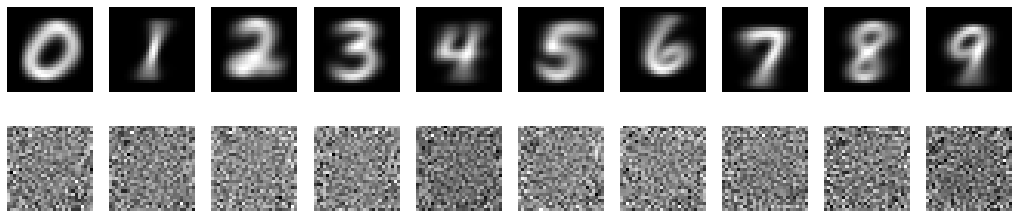

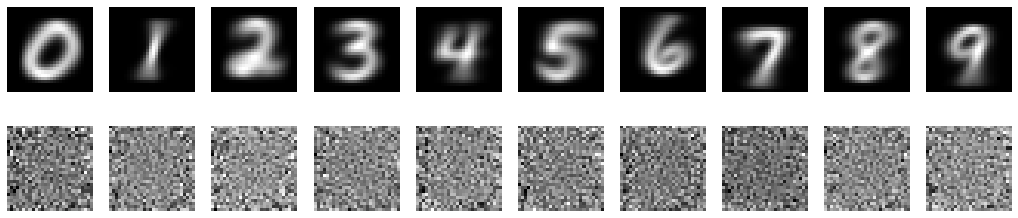

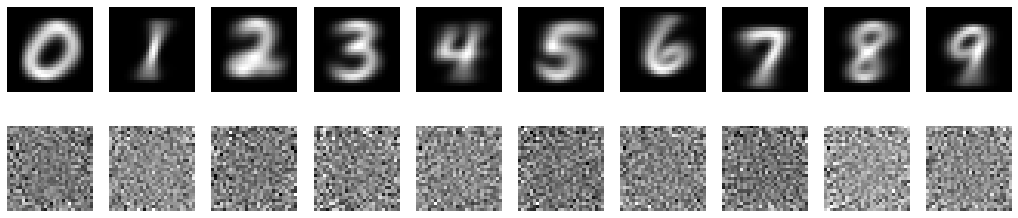

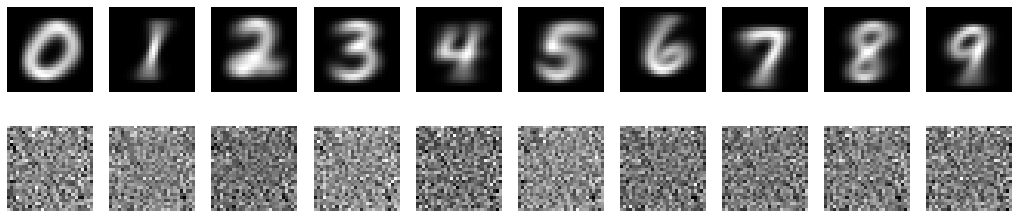

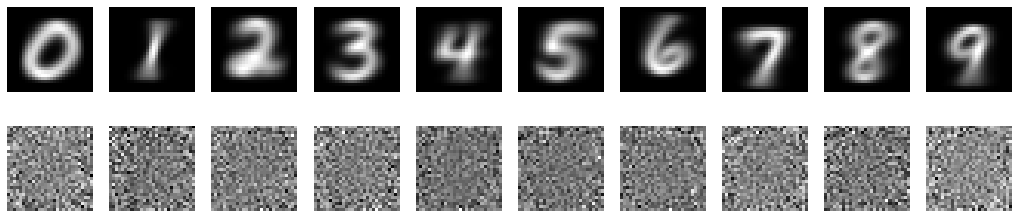

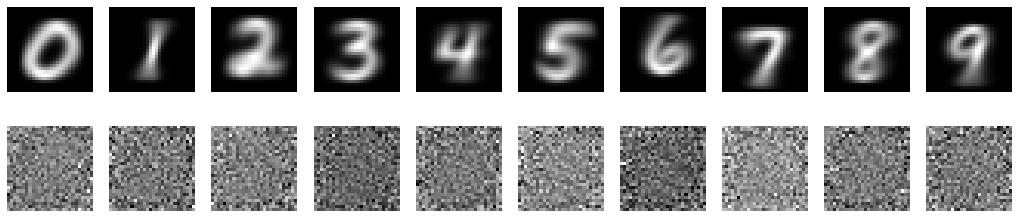

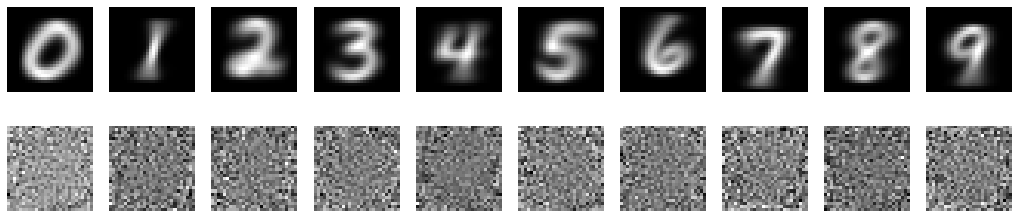

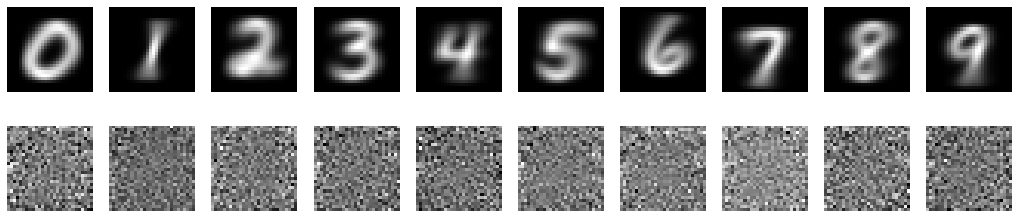

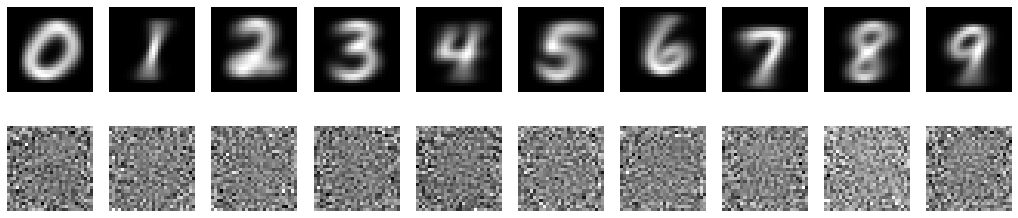

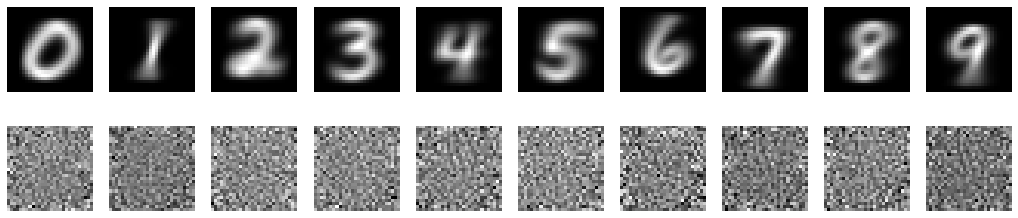

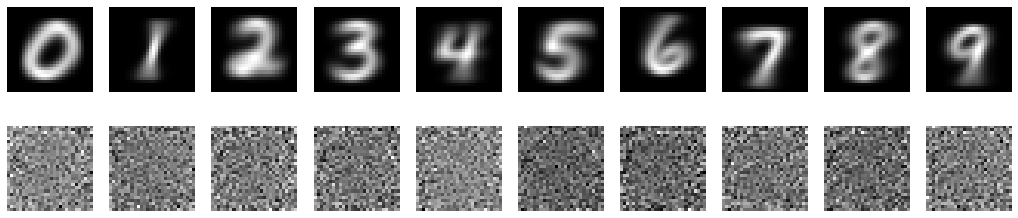

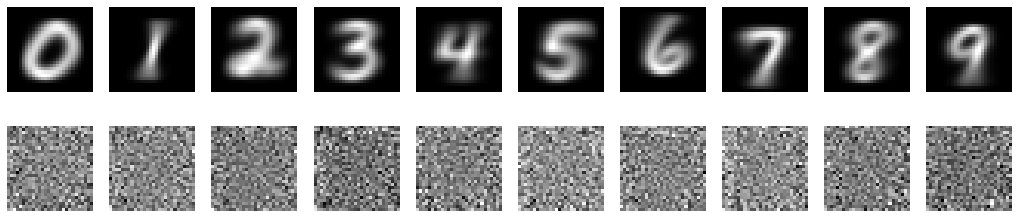

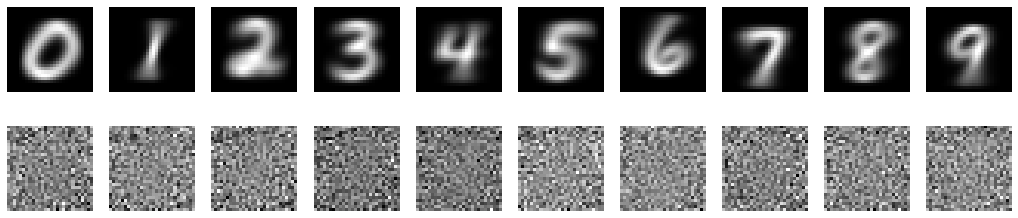

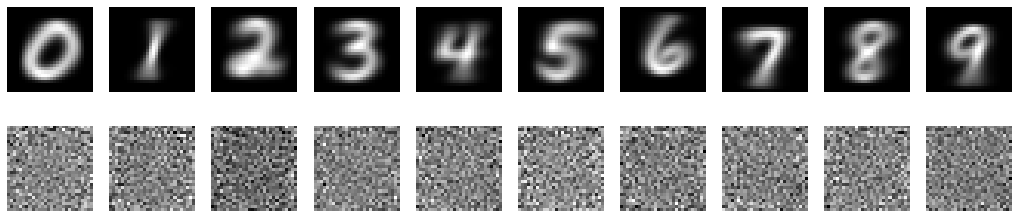

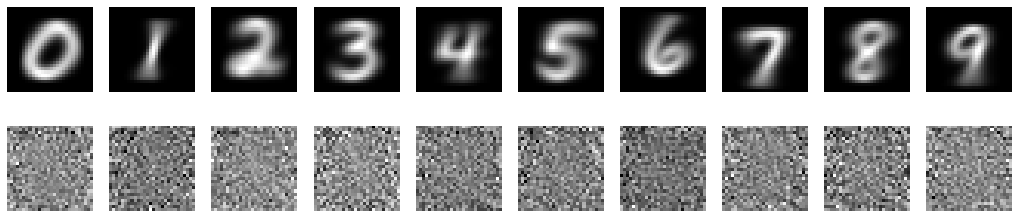

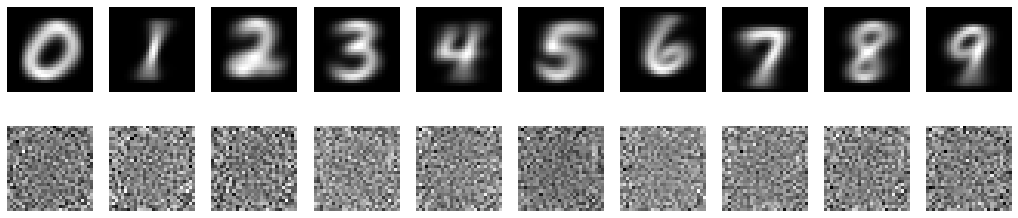

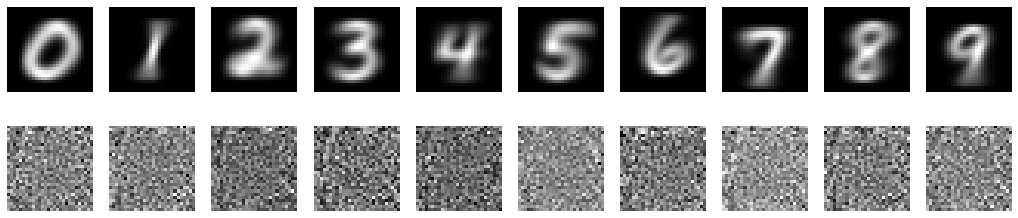

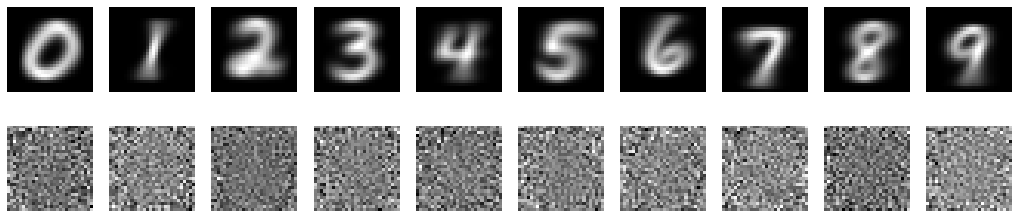

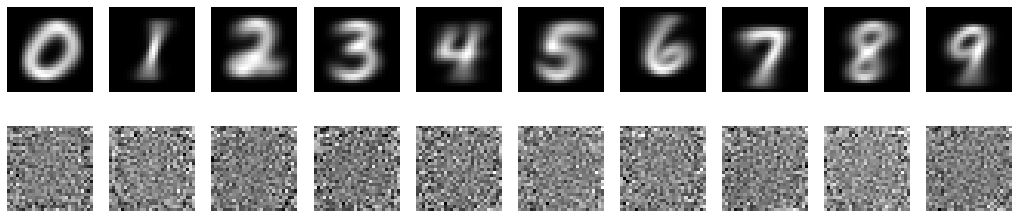

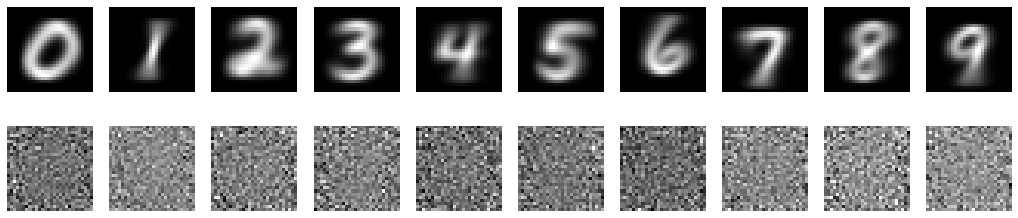

In [616]:
cos_similarities = []
for i in range(0, 10):
    cos_similarities.append([])
    
means_of_class_c = []

for net0 in net_nd:
    net0.Allocate(classes)
    net0.Reset()
    net0.SetvDecay(0.04)
    net0.layers[0].SetFF()
    net0.layers[-1].SetFF()
    z = net0.Predict(60., classes, dt=0.002)

    plt.figure(figsize=[18,4])
    for c in range(10):
        images_of_class_c = train[0][train[1][:,c]==1]
        means_of_class_c.append(torch.mean(images_of_class_c, dim=0).cpu())

        generated = z[c].cpu()
        cos_similarities[c].append(np.dot(generated, means_of_class_c[-1]) / (np.linalg.norm(generated)*np.linalg.norm(means_of_class_c[-1])))
        print(cos_similarities[c][-1])

        plt.subplot(2,10,c+1); DrawDigit(means_of_class_c[-1])
        plt.subplot(2,10,c+11); DrawDigit(generated)

In [663]:
print(len(cos_similarities[c]))

20


In [665]:
mean_cos_sim = 0
for c in range(0, 10):
    for d in range(0, 20):
        mean_cos_sim += cos_similarities[c][d]
mean_cos_sim /= 200.0
print(mean_cos_sim)

0.00978127843089169


In [666]:
max_cos_sim = 0
for c in range(0, 10):
    for d in range(0, 20):
        if cos_similarities[c][d] > max_cos_sim:
            max_cos_sim = cos_similarities[c][d]
print(max_cos_sim)

0.11699343


In [640]:
print([np.ndarray.flatten(np.asarray(cos_similarities)), np.ndarray.flatten(np.asarray(cos_similarities_d))])

(array([ 0.02059651,  0.0146583 ,  0.00244411,  0.01419773,  0.04003935,
        0.01721448, -0.00345379,  0.02684506,  0.0528901 , -0.00327488,
       -0.03886203,  0.01940222,  0.0547587 ,  0.00954835,  0.00771423,
       -0.03759994, -0.0361692 ,  0.00834642,  0.04446451,  0.01067392,
        0.06581186,  0.01804787,  0.0498529 , -0.02623159,  0.01440856,
        0.05618769,  0.01555822,  0.02067231,  0.0463269 ,  0.04085953,
       -0.01707576, -0.02633505,  0.05917512,  0.05068348,  0.04622352,
       -0.06044641, -0.03998899, -0.0073147 ,  0.02197419,  0.05122308,
        0.03202078, -0.00887763,  0.00452489, -0.01194247,  0.01387601,
        0.03695868,  0.0463846 , -0.01132672,  0.02746736, -0.01177567,
       -0.04736651, -0.02952403,  0.08600921,  0.00054122,  0.01964616,
       -0.04309506, -0.04832884,  0.02927729, -0.01796765,  0.02553426,
        0.039979  , -0.03539855,  0.02602855, -0.01935218,  0.00310054,
        0.0319371 ,  0.01678173,  0.00157989,  0.05531481,  0.0

In [694]:
xasd = np.ndarray.flatten(np.asarray(np.add(cos_similarities_d, -0.3)))

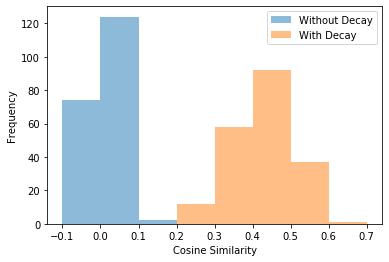

In [696]:
colors = ['red', 'blue']
plt.rcParams["font.family"] = "Times New Roman"

#n, bins, patches = plt.hist([np.ndarray.flatten(np.asarray(cos_similarities)), np.ndarray.flatten(np.asarray(cos_similarities_d))], bins=[-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], color=colors, rwidth=1.0, stacked=True);
plt.hist(np.ndarray.flatten(np.asarray(cos_similarities)), bins, alpha=0.5, label='x')
plt.hist(np.ndarray.flatten(np.asarray(cos_similarities_d)), bins, alpha=0.5, label='y')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(['Without Decay', 'With Decay'])
plt.savefig("bar_comp.pdf", format='pdf')
#a = np.array(plt.axis())
#plt.axis(a);

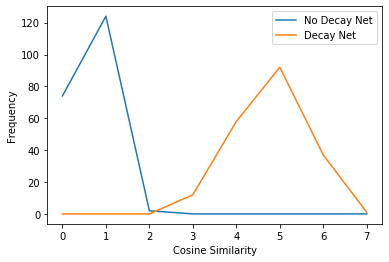

In [674]:
plt.plot(n[0])
plt.plot(n[1])
plt.legend(['No Decay Net', 'Decay Net'])
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.savefig("bar_comp.pdf", format='pdf')

# Investigate standard deviation of middle layer

In [120]:
print(np.mean(np.abs(net1.layers[1].v.cpu().numpy())))

0.030038562


In [121]:
print(np.mean(np.abs(net0.layers[1].v.cpu().numpy())))

0.030165588


In [180]:
np.amax(np.abs(np.asarray(net1.connections[1].M.cpu())))

0.06990507

In [179]:
np.mean(np.abs(np.asarray(net1.connections[1].M.cpu())))

0.022213204

In [122]:
for network in net_decay:
    print(network.connections[0].activation_function)

tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh


In [90]:
#del v_nodecay[-1]
'''
for i in range (0, 5):
    del net_decay[0]
    del net_nodecay[0]
    del v_decay[0]
    del v_nodecay[0]
    del M0_decay[0]
    del M1_decay[0]
    del M0_nodecay[0]
    del M1_nodecay[0]
    del W0_decay[0]
    del W1_decay[0]
    del W0_nodecay[0]
    del W1_nodecay[0]
'''

In [123]:
vnd = np.array([v.reshape((1,600000))[0] for v in v_nodecay])

print(np.average(vnd, axis=0))
print(np.std(vnd, axis=0))

[-0.01198681  0.01191355  0.00117927 ... -0.0010872   0.00440474
  0.00543636]
[0.03654356 0.02791179 0.0352925  ... 0.04306975 0.04022612 0.03679167]


In [124]:
vd = np.array([v.reshape((1,600000))[0] for v in v_decay])

print(np.average(vd, axis=0))
print(np.std(vd, axis=0))

[-0.01058173  0.01696048 -0.00220555 ...  0.00345089 -0.00264045
  0.00835072]
[0.03294104 0.02774801 0.02872275 ... 0.03506876 0.03185759 0.03611497]


In [125]:
c=2
for v_nd, v_d in zip(v_nodecay, v_decay):
    print(np.linalg.norm(v_nd[c,:]), np.linalg.norm(v_d[c,:]))

0.8355295 0.80990136
0.8189958 0.7501976
1.1505103 0.74776584
1.048588 0.752449
0.80575264 0.81847537
0.8892024 0.8217081
0.86852986 0.69509524
0.8997406 0.75589234
0.86356825 0.76295364
0.9449285 0.7875088
0.99930954 0.78161484
0.8823978 0.84798723
0.9722073 0.8239513
0.9436107 0.8483779
0.88388443 0.7278961
0.8962965 0.8150145
0.93928367 0.805521
0.9174016 0.7185121
0.9367155 0.74385285
0.95353794 0.7930162


In [126]:
np.save('v_decay_MNIST_tanh.npy', v_decay)
np.save('v_nodecay_MNIST_tanh.npy', v_nodecay)

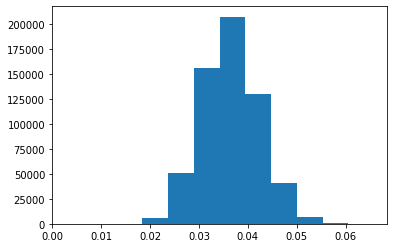

In [127]:
plt.hist(np.std(vnd, axis=0));
a = np.array(plt.axis())
a[0] = 0.
plt.axis(a);

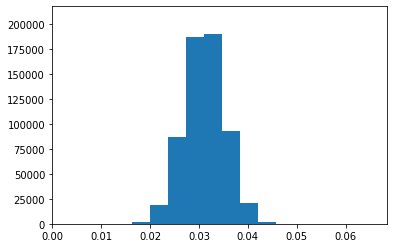

In [128]:
plt.hist(np.std(vd, axis=0));
plt.axis(a);

## Process the weight matrices

In [152]:
for c in net1.connections:
    print(c.M)

tensor([[-0.0310,  0.0363, -0.0170,  ..., -0.0416, -0.0171,  0.0088],
        [ 0.0135,  0.0116, -0.0124,  ...,  0.0193, -0.0283,  0.0412],
        [-0.0362, -0.0120,  0.0184,  ...,  0.0190,  0.0356,  0.0198],
        ...,
        [ 0.0247,  0.0454, -0.0403,  ..., -0.0327, -0.0141, -0.0061],
        [ 0.0289,  0.0017,  0.0492,  ...,  0.0282, -0.0102, -0.0212],
        [ 0.0547,  0.0356, -0.0207,  ..., -0.0076, -0.0104, -0.0385]],
       device='cuda:0')
tensor([[ 2.8509e-21, -1.0837e-21, -9.2158e-22,  ...,  9.7379e-22,
         -1.7532e-21,  8.8027e-21],
        [ 4.5904e-21,  2.4970e-21, -3.4160e-21,  ...,  3.4825e-21,
         -1.5005e-21,  3.0618e-21],
        [ 3.4459e-21,  2.4878e-21,  3.4791e-21,  ..., -1.4842e-21,
         -3.3836e-21, -4.6420e-21],
        ...,
        [ 1.6109e-21,  7.8449e-21,  6.2166e-21,  ..., -1.8602e-22,
         -3.5031e-21, -2.2483e-20],
        [-1.1668e-21,  2.0466e-22, -3.5726e-21,  ...,  1.2902e-21,
          1.8318e-21, -6.2073e-22],
        [-2.74

In [130]:
M0_decay2 = np.array([np.array(M.cpu()) for M in M0_decay])
M1_decay2 = np.array([np.array(M.cpu()) for M in M1_decay])
np.savez('Md01_tanh.npz', M0_decay2, M1_decay2)

In [131]:
M0_nodecay2 = np.array([np.array(M.cpu()) for M in M0_nodecay])
M1_nodecay2 = np.array([np.array(M.cpu()) for M in M1_nodecay])
np.savez('Mnd01_tanh.npz', M0_nodecay2, M1_nodecay2)

In [132]:
npzfile = np.load('Md01_tanh.npz')
M0_decay = npzfile['arr_0']
M1_decay = npzfile['arr_1']

In [133]:
npzfile = np.load('Mnd01_tanh.npz')
M0_nodecay = npzfile['arr_0']
M1_nodecay = npzfile['arr_1']

In [187]:
Md = []
for M1,M0 in zip(M1_decay, M0_decay):
    #M = M1 @ M0
    #M2 = M.reshape((1,np.prod(np.shape(M))))[0]
    #Md.append(np.array(M2))
    
    # M = M1
    M2 = M1.reshape((1,np.prod(np.shape(M1))))[0]
    Md.append(np.array(M2))
Md = np.array(Md)

In [188]:
Mnd = []
for M1,M0 in zip(M1_nodecay, M0_nodecay):
    #M = M1 @ M0
    #M2 = M.reshape((1,np.prod(np.shape(M))))[0]
    #Mnd.append(np.array(M2))

    M2 = M1.reshape((1,np.prod(np.shape(M1))))[0]
    Mnd.append(np.array(M2))
    
Mnd = np.array(Mnd)

In [192]:
print(Mnd.shape)
print(Md.shape)

(20, 470400)
(20, 470400)


In [136]:
print(np.average(Mnd, axis=0))
print(np.std(Mnd, axis=0))
print(np.mean(np.std(Mnd, axis=0)))

[ 0.00370213  0.06093169  0.02648482 ... -0.02447139  0.05815231
 -0.00132615]
[0.17501271 0.25693977 0.17222902 ... 0.21614827 0.17894281 0.26296717]
0.13848111


In [137]:
print(np.average(Md, axis=0))
print(np.std(Md, axis=0))
print(np.mean(np.std(Md, axis=0)))

[ 2.7508774e-22  1.0463495e-20  1.2105584e-20 ... -1.0966653e-20
  6.5074448e-21  2.7159577e-20]
[1.0981482e-20 3.2518509e-20 3.3676051e-20 ... 7.0835205e-20 4.2631519e-20
 1.6765489e-19]
0.004453413


In [194]:
np.mean(np.abs(Mnd))

0.01966575

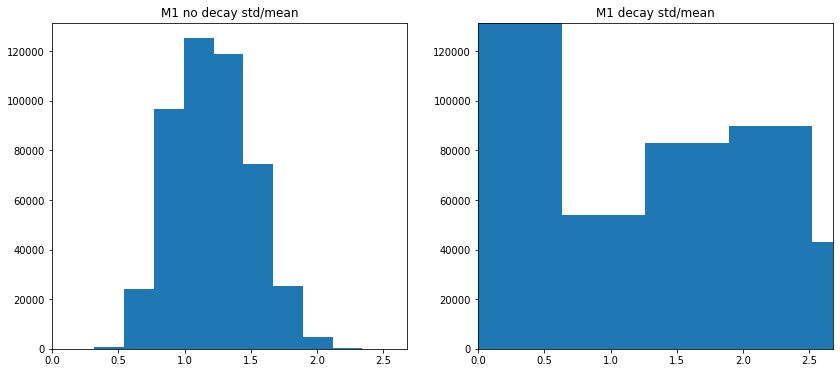

In [195]:
plt.figure(figsize=(14,6));
plt.subplot(1,2,1); plt.hist(np.std(Mnd, axis=0) / np.mean(np.abs(Mnd)));
plt.title('M1 no decay std/mean')
a = np.array(plt.axis())
a[0] = 0.
plt.axis(a);

plt.subplot(1,2,2); plt.hist(np.std(Md, axis=0) / np.mean(np.abs(Md)));
plt.title('M1 decay std/mean')
plt.axis(a);

In [140]:
for M1,M0 in zip(M1_nodecay, M0_nodecay):
    M = M1 @ M0
    print(np.linalg.svd(M0)[1], np.linalg.svd(M1)[1])

[4.424057  4.3399334 4.19754   4.1777005 4.016908  3.915992  3.8697305
 3.8265579 3.7822104 3.6612916] [6.785651   6.042443   3.7868135  3.477055   3.1875458  3.0245516
 2.9196332  2.8194969  2.6880646  2.4627326  2.3517914  2.034326
 1.3850148  1.1868542  0.9696638  0.96753454 0.9634815  0.9498639
 0.94737715 0.94426316 0.9411221  0.93195325 0.9267752  0.92376053
 0.9204034  0.9176707  0.91186863 0.9101408  0.909093   0.90594786
 0.8984917  0.8952672  0.8925381  0.8867272  0.88580996 0.88496625
 0.8791725  0.8782163  0.8745179  0.87156975 0.8690922  0.86617196
 0.8619939  0.8599508  0.85759926 0.85519373 0.85110354 0.84922993
 0.84753853 0.84692776 0.84320074 0.8421178  0.8387365  0.83590907
 0.8352569  0.831113   0.8289142  0.8273287  0.8249712  0.8212333
 0.8191819  0.8145854  0.8134966  0.8105473  0.80937153 0.8066362
 0.8041053  0.80219007 0.7998228  0.7967363  0.7952553  0.7936888
 0.79287493 0.79068947 0.7873945  0.7841513  0.7806704  0.7795403
 0.7781551  0.7771992  0.77534807 

[4.4689083 4.27428   4.2321234 4.010466  3.9935513 3.9471836 3.7973096
 3.735818  3.5911477 3.4195247] [5.9267144  3.9927726  3.7976568  3.600043   3.2351987  3.1728802
 3.129379   2.9244874  2.8616288  2.3951154  2.111525   1.7566984
 1.4638184  1.0453786  0.9590488  0.95524496 0.9543891  0.9457996
 0.9429035  0.9372513  0.9338003  0.92851937 0.92658865 0.9199756
 0.91961545 0.9108474  0.90729344 0.90553004 0.9017818  0.897091
 0.89447707 0.8925382  0.8904618  0.8865769  0.8827786  0.88222706
 0.8773222  0.87621844 0.8729561  0.8709929  0.8706377  0.86572313
 0.8617162  0.86087644 0.85879844 0.857114   0.8556204  0.8524378
 0.84993654 0.8450422  0.84279394 0.84022385 0.8391212  0.8374808
 0.8340141  0.82997006 0.8267127  0.8239445  0.82163465 0.82120526
 0.82055354 0.81714785 0.81368804 0.8115581  0.8090096  0.80754375
 0.8057093  0.80381024 0.79975045 0.79939395 0.7959849  0.7933693
 0.7927214  0.79054683 0.78870815 0.78643143 0.78168696 0.78051263
 0.7798579  0.7771025  0.77640414 0

 3.7504518 3.6972618 3.6471977] [6.3658814  4.040099   3.4984083  3.2709517  3.1697922  3.0353355
 2.9677985  2.905342   2.6161084  2.4692357  2.2597103  2.2245214
 1.9730603  1.2444088  0.9779552  0.96580815 0.96284896 0.95642215
 0.9516817  0.9452929  0.94360757 0.93430626 0.92964625 0.9220036
 0.92060995 0.9152722  0.91144055 0.9089398  0.9064217  0.90141296
 0.8995967  0.89741194 0.89404845 0.89294535 0.8882603  0.88504136
 0.8812768  0.879415   0.87641054 0.87477124 0.87415427 0.8700271
 0.86327714 0.8617609  0.86018175 0.8548518  0.8529511  0.8519383
 0.8500016  0.8449889  0.84235525 0.84051776 0.83778113 0.8366479
 0.8355819  0.8329068  0.8296544  0.82663006 0.8246211  0.82133824
 0.8211338  0.81804615 0.8129958  0.8115459  0.8092054  0.80772716
 0.8046427  0.80109954 0.79832757 0.7956179  0.7954058  0.7947497
 0.7911482  0.78863525 0.78805107 0.7850174  0.7826844  0.7807538
 0.77932316 0.77740437 0.77571124 0.7748214  0.7702122  0.7670969
 0.76493484 0.76281995 0.76119506 0.758

[4.4015727 4.3358355 4.2594786 4.244654  4.126659  4.005785  3.9444475
 3.749796  3.678027  3.5521936] [6.131403   4.2648387  3.7342358  3.371074   3.1427734  3.0296164
 2.867469   2.8026152  2.6962392  2.3917925  2.194935   2.0730028
 1.5977587  1.2105526  0.9685428  0.9644363  0.95725685 0.9506966
 0.9419359  0.9366391  0.93142605 0.92795354 0.9255296  0.9230135
 0.9191887  0.9147462  0.9123701  0.9040726  0.90167433 0.89793247
 0.8942412  0.8928861  0.88777566 0.88408995 0.8813895  0.87808704
 0.8776529  0.87503105 0.87231165 0.8687779  0.8650803  0.8627522
 0.8597486  0.85808516 0.8562586  0.8523912  0.8507509  0.8494077
 0.846325   0.8440226  0.8422327  0.83928174 0.8361859  0.8325259
 0.8295845  0.82862955 0.8269011  0.8265055  0.82491094 0.82080096
 0.81759363 0.8157255  0.81493676 0.81421727 0.8122739  0.80600977
 0.804481   0.8017468  0.79857785 0.79452586 0.7940946  0.7919939
 0.7910698  0.78783655 0.7857161  0.7834193  0.78229505 0.77879643
 0.7769203  0.77127934 0.7703543  

[4.3854256 4.2683077 4.24205   4.1210856 4.105061  3.8284853 3.7898285
 3.7535589 3.6168756 3.569438 ] [6.417622   6.15903    3.7498415  3.5234492  3.2427893  3.050219
 2.9692955  2.7988124  2.7538729  2.5195496  2.268104   2.044754
 1.6727931  1.3313798  0.97335935 0.964906   0.95842963 0.9499402
 0.94351846 0.94203144 0.934763   0.930977   0.9267349  0.91852003
 0.9183898  0.9142549  0.91184    0.90618116 0.9047657  0.90356857
 0.8997838  0.8953355  0.89461225 0.88975775 0.88467294 0.8813289
 0.8755883  0.8751625  0.8703936  0.86964464 0.86478984 0.8614967
 0.86036617 0.85863924 0.8547223  0.8537188  0.85056055 0.84822565
 0.84681314 0.8414492  0.8393513  0.83727574 0.8342668  0.83232075
 0.83029485 0.8295244  0.82706666 0.82503504 0.822612   0.8196379
 0.81828934 0.8160952  0.8128709  0.81244683 0.8088835  0.8053212
 0.8046409  0.80290717 0.79907054 0.7976483  0.7950053  0.7930909
 0.79096025 0.78940105 0.78748614 0.78383374 0.78286225 0.7812621
 0.7777414  0.77487624 0.7741962  0.7

[4.401051  4.2755113 4.2102203 4.0574865 4.019856  3.9696543 3.8439503
 3.7201304 3.6742477 3.508273 ] [5.5473804  3.6902714  3.6300032  3.371515   3.3319542  3.269036
 3.0582142  2.8108606  2.6553836  2.4307437  2.2666755  2.0329525
 1.6436746  1.2091172  0.9650738  0.9637919  0.9542778  0.945553
 0.9392747  0.93573827 0.9317336  0.9301431  0.9255639  0.924554
 0.91691583 0.91321254 0.9115549  0.9072272  0.90475506 0.898984
 0.89610314 0.89162916 0.8890895  0.88568056 0.8833588  0.8816578
 0.87690455 0.8753451  0.8701566  0.8677538  0.8653516  0.8630455
 0.8615116  0.85848457 0.85625166 0.852361   0.8486918  0.8478524
 0.8466211  0.84334815 0.8406098  0.837413   0.83437324 0.83417165
 0.829844   0.827427   0.8258094  0.824174   0.8198076  0.81916904
 0.8157379  0.81325066 0.812562   0.8096757  0.80704486 0.8042338
 0.8040394  0.80291975 0.8010199  0.7986693  0.79665047 0.79393023
 0.79122365 0.7894915  0.7876458  0.7846463  0.7829324  0.78081286
 0.7784908  0.77670926 0.77304345 0.770

 3.8590975 3.677865  3.6492808] [6.2804418  4.2798824  3.8074658  3.6732025  3.2750099  3.1136734
 2.9301531  2.864061   2.683733   2.6259756  2.4311147  1.8976867
 1.592636   1.2635057  0.97000855 0.9615241  0.95609015 0.94565
 0.9385216  0.935789   0.93319434 0.92687684 0.9195007  0.9189317
 0.91460544 0.90952474 0.9064359  0.89953774 0.8991969  0.8964674
 0.89422935 0.8909744  0.8908244  0.88410723 0.88222665 0.88101095
 0.8780059  0.87463063 0.8725093  0.86997026 0.8679235  0.8651535
 0.8622527  0.8603687  0.8568482  0.8545555  0.8530439  0.8486073
 0.8454272  0.84380746 0.841792   0.8392474  0.83460027 0.83268934
 0.83146524 0.82680875 0.82509565 0.8249741  0.823407   0.818584
 0.8161916  0.8158421  0.8111879  0.81008947 0.8068595  0.80372995
 0.8027796  0.79971284 0.79646695 0.79564244 0.7932374  0.7898934
 0.789467   0.7874989  0.7855388  0.78393745 0.7808387  0.7789337
 0.7776609  0.7745235  0.77176046 0.7702912  0.7666484  0.7653443
 0.7642227  0.7620517  0.7599209  0.75633645

 3.6969004 3.6486082 3.492401 ] [7.8726563  4.599647   3.863852   3.5652642  3.2789092  3.052844
 2.8678145  2.715786   2.5044024  2.2529633  2.1439493  1.8080678
 1.7195835  1.3038999  0.9570344  0.95551485 0.9479805  0.9459721
 0.9426875  0.94080746 0.93538755 0.92263764 0.9197307  0.9191296
 0.91674733 0.9144231  0.90993494 0.9061985  0.90433216 0.90100765
 0.89932567 0.8954086  0.8907115  0.8887784  0.886116   0.88186747
 0.88029546 0.8763942  0.87311083 0.870909   0.87027574 0.8615612
 0.8589152  0.8569926  0.85547596 0.8515913  0.8493281  0.84868944
 0.84458065 0.84163594 0.83960235 0.8351153  0.8346706  0.830643
 0.82735157 0.82565737 0.82150435 0.82054746 0.81963134 0.81823677
 0.81612235 0.812698   0.8104142  0.80854034 0.8057282  0.8048715
 0.802806   0.8000548  0.79831207 0.79650444 0.794855   0.7915297
 0.78974444 0.7875956  0.7848335  0.78188074 0.78108287 0.7801285
 0.7772004  0.7749541  0.77385986 0.7724929  0.77040327 0.76612437
 0.7643925  0.7625078  0.7594323  0.75801

In [141]:
for M1,M0 in zip(M1_decay, M0_decay):
    M = M1 @ M0
    print(np.linalg.svd(M0)[1], np.linalg.svd(M1)[1])

[0.7587324  0.7106733  0.68718994 0.6599219  0.63853157 0.6222054
 0.6127065  0.6062622  0.58925736 0.5269861 ] [4.82269078e-01 4.46633101e-01 4.25404698e-01 3.99183840e-01
 3.80459368e-01 3.69614363e-01 3.49342167e-01 3.37955028e-01
 3.25454593e-01 1.46144271e-01 5.54005208e-04 5.02232288e-04
 4.65788529e-04 4.47604543e-04 3.91816226e-04 3.60320555e-04
 3.44217784e-04 3.26946174e-04 2.80120905e-04 2.76681851e-04
 1.89875544e-04 1.69017585e-04 1.58648356e-04 1.49161744e-04
 1.45322178e-04 1.40835298e-04 1.33109526e-04 1.28688931e-04
 1.18199045e-04 1.16147741e-04 1.11163412e-04 1.09264736e-04
 1.05115534e-04 1.01247417e-04 9.87723033e-05 9.06541900e-05
 8.90371011e-05 8.63639580e-05 8.23709197e-05 7.88598409e-05
 7.64623110e-05 7.32817498e-05 7.10122331e-05 7.08340376e-05
 6.86444982e-05 6.55351250e-05 6.47429260e-05 6.37622361e-05
 6.11308933e-05 5.99480773e-05 5.82950343e-05 5.73983780e-05
 5.59030195e-05 5.29910976e-05 5.26124204e-05 4.94433007e-05
 4.72076354e-05 4.59431285e-05 4.4

[0.7149441  0.70944977 0.67951614 0.66982126 0.65771514 0.64747417
 0.6236378  0.6048171  0.5816276  0.530215  ] [4.66916084e-01 4.46410120e-01 4.19195235e-01 4.02019382e-01
 3.88186216e-01 3.63539606e-01 3.49204212e-01 3.28348428e-01
 3.01182210e-01 1.35681584e-01 5.25106443e-04 4.63293429e-04
 4.52551729e-04 4.10408335e-04 4.06938896e-04 3.85158695e-04
 3.35175078e-04 3.21433210e-04 2.97596765e-04 2.64929608e-04
 1.78387985e-04 1.62321463e-04 1.41643861e-04 1.32121277e-04
 1.28190964e-04 1.19307027e-04 1.16196104e-04 1.13894253e-04
 1.06184372e-04 9.83612772e-05 9.40387399e-05 9.00751838e-05
 8.67179333e-05 8.58839267e-05 8.32672958e-05 8.06684184e-05
 7.82076459e-05 7.60153052e-05 7.26922299e-05 7.10697859e-05
 6.86599669e-05 6.67105560e-05 6.49679860e-05 6.43817984e-05
 6.29748465e-05 6.19640123e-05 5.90193522e-05 5.69791409e-05
 5.56966479e-05 5.36288971e-05 5.21736401e-05 5.06262986e-05
 5.01514260e-05 4.92940380e-05 4.79447081e-05 4.64188161e-05
 4.56981579e-05 4.40632903e-05 4.

[0.73039997 0.71028996 0.6948643  0.67500305 0.6541881  0.63120323
 0.61822623 0.6062265  0.6007148  0.52413374] [4.62434798e-01 4.56448793e-01 4.39431727e-01 4.34467703e-01
 3.92084986e-01 3.50979865e-01 3.44597369e-01 3.26379567e-01
 3.17173213e-01 1.36433735e-01 5.54514932e-04 5.27668279e-04
 4.70774510e-04 4.39305004e-04 4.18460259e-04 3.97819822e-04
 3.81865946e-04 3.46288842e-04 3.22895648e-04 2.63201451e-04
 1.99264352e-04 1.72344066e-04 1.60988275e-04 1.55227041e-04
 1.33713722e-04 1.32330417e-04 1.31181674e-04 1.22820638e-04
 1.14407318e-04 1.09580244e-04 1.05507330e-04 1.01249818e-04
 9.87147432e-05 9.49785390e-05 9.25266650e-05 8.85050904e-05
 8.59819775e-05 8.42047521e-05 8.08590994e-05 7.68540704e-05
 7.45225771e-05 7.15525457e-05 7.03338592e-05 6.87081192e-05
 6.73533577e-05 6.42821396e-05 6.30813374e-05 5.96937534e-05
 5.92482756e-05 5.64771872e-05 5.52679521e-05 5.43569331e-05
 5.31015066e-05 5.22620612e-05 5.08910343e-05 4.89551239e-05
 4.78720904e-05 4.68484322e-05 4.

[0.7438604  0.7262917  0.70652556 0.6679662  0.6500521  0.63811696
 0.6222001  0.58961785 0.568551   0.5208694 ] [4.75251436e-01 4.43496048e-01 4.25896585e-01 4.19757813e-01
 3.78052801e-01 3.76663834e-01 3.62755567e-01 3.47272128e-01
 3.03445101e-01 1.44041523e-01 5.07892051e-04 4.83384967e-04
 4.52997920e-04 4.28013853e-04 4.03228740e-04 3.63749336e-04
 3.22913344e-04 3.07184528e-04 2.52724072e-04 2.35407686e-04
 1.84659584e-04 1.78631410e-04 1.53706336e-04 1.47325030e-04
 1.35138500e-04 1.34775750e-04 1.25473336e-04 1.20292789e-04
 1.13627371e-04 1.12432797e-04 1.07251086e-04 1.01957725e-04
 9.80091645e-05 9.21475148e-05 8.94556651e-05 8.81899250e-05
 8.56067272e-05 8.17330510e-05 7.77240857e-05 7.39769748e-05
 7.13419940e-05 6.92715112e-05 6.78846336e-05 6.53987663e-05
 6.35517063e-05 6.09165108e-05 5.80573724e-05 5.71429664e-05
 5.48450917e-05 5.37092892e-05 5.27895500e-05 5.01234135e-05
 4.98767695e-05 4.80771996e-05 4.70642008e-05 4.59442890e-05
 4.53482353e-05 4.41719021e-05 4.

[0.76141375 0.7370273  0.71028495 0.70060515 0.6480571  0.62964284
 0.5815753  0.56614673 0.559388   0.5108512 ] [4.70506340e-01 4.40647483e-01 4.23492104e-01 4.09796447e-01
 3.96120012e-01 3.49895716e-01 3.35161865e-01 3.07500452e-01
 2.90193945e-01 1.42757311e-01 5.12750878e-04 4.75287379e-04
 4.65609482e-04 4.32490982e-04 4.19003103e-04 3.80121492e-04
 3.67408560e-04 3.27022746e-04 3.04454152e-04 2.77368526e-04
 1.91807063e-04 1.80124494e-04 1.69284656e-04 1.60125564e-04
 1.51590080e-04 1.48843086e-04 1.45708618e-04 1.37997049e-04
 1.26044222e-04 1.21705634e-04 1.13990012e-04 1.07647873e-04
 1.06042375e-04 1.03807426e-04 9.89287510e-05 9.06800051e-05
 8.92513272e-05 8.65302936e-05 8.50243669e-05 8.26039832e-05
 8.00033886e-05 7.61461415e-05 7.37986775e-05 7.06707797e-05
 7.02830876e-05 6.75423144e-05 6.52585586e-05 6.31581643e-05
 6.22547886e-05 6.20069695e-05 5.81455643e-05 5.66123417e-05
 5.45014409e-05 5.37674932e-05 5.19278110e-05 5.06115175e-05
 4.95371605e-05 4.78889706e-05 4.

[0.7508904  0.7120068  0.69946593 0.68073803 0.6737707  0.62564933
 0.6054147  0.5948047  0.5546066  0.49387452] [4.96224046e-01 4.47541744e-01 4.34196472e-01 4.06731546e-01
 4.02808517e-01 3.66619587e-01 3.44628274e-01 3.18487912e-01
 3.04860502e-01 1.40715018e-01 5.61551482e-04 4.89904196e-04
 4.42852150e-04 4.21372039e-04 4.15947929e-04 3.83376959e-04
 3.52523726e-04 3.09044146e-04 2.93829391e-04 2.68838601e-04
 2.25592070e-04 1.57253016e-04 1.49136671e-04 1.49070125e-04
 1.32218192e-04 1.25508814e-04 1.15103212e-04 1.11881483e-04
 1.05452171e-04 1.04420869e-04 9.87391977e-05 9.34355703e-05
 8.97915597e-05 8.86439157e-05 8.52597586e-05 7.95538799e-05
 7.90464546e-05 7.64041615e-05 7.36271322e-05 7.15698188e-05
 6.89818044e-05 6.54968171e-05 6.41607767e-05 6.15819372e-05
 6.11162104e-05 5.97294384e-05 5.83210240e-05 5.56252999e-05
 5.36894113e-05 5.33134298e-05 5.21401598e-05 4.90175626e-05
 4.84903649e-05 4.63083124e-05 4.60233496e-05 4.49417748e-05
 4.26460319e-05 4.20565557e-05 4.

[0.7641889  0.7393461  0.6948946  0.67674744 0.6687509  0.6415883
 0.6151298  0.5757448  0.556617   0.5158148 ] [4.83471006e-01 4.37685758e-01 4.24249798e-01 4.14681435e-01
 3.94799441e-01 3.73134911e-01 3.47724169e-01 3.10088217e-01
 2.79739141e-01 1.41512126e-01 5.13324747e-04 5.04369091e-04
 4.34185145e-04 4.28691332e-04 4.13645146e-04 3.78779310e-04
 3.58066958e-04 3.40614206e-04 3.02950357e-04 2.85916758e-04
 2.07710575e-04 1.85218232e-04 1.64836907e-04 1.59225994e-04
 1.44112011e-04 1.37165523e-04 1.28996326e-04 1.27087347e-04
 1.22622005e-04 1.16037816e-04 1.10866073e-04 1.06081752e-04
 1.05099913e-04 1.01792888e-04 9.58364981e-05 9.41245453e-05
 9.12528776e-05 9.06063506e-05 8.76198756e-05 8.07921024e-05
 7.88170801e-05 7.82725328e-05 7.55780275e-05 7.20549797e-05
 7.00238088e-05 6.58950157e-05 6.55558106e-05 6.22335137e-05
 6.11332580e-05 5.80640590e-05 5.77269784e-05 5.60144290e-05
 5.47335330e-05 5.26092881e-05 5.17916997e-05 4.95772583e-05
 4.86547760e-05 4.83409276e-05 4.6

[0.7620029  0.749428   0.7168781  0.68978465 0.67017263 0.622761
 0.5717947  0.55688006 0.53622454 0.4988212 ] [4.76482898e-01 4.55232412e-01 4.49589759e-01 4.33050185e-01
 3.90707552e-01 3.67125481e-01 3.19236189e-01 2.88895249e-01
 2.74875700e-01 1.30709633e-01 5.62728848e-04 5.07730350e-04
 4.76918067e-04 4.51324071e-04 4.12707130e-04 3.81142221e-04
 3.49056383e-04 2.89768417e-04 2.61277281e-04 2.33054452e-04
 1.74141445e-04 1.67031016e-04 1.58858093e-04 1.43264930e-04
 1.37578594e-04 1.32675792e-04 1.30032087e-04 1.24357030e-04
 1.19337834e-04 1.07981468e-04 1.00914833e-04 9.80916739e-05
 9.57554366e-05 9.19543745e-05 9.09201044e-05 8.62025699e-05
 8.31697980e-05 8.10348429e-05 7.99812842e-05 7.48163657e-05
 7.13105037e-05 7.05463099e-05 6.73873947e-05 6.57768614e-05
 6.40655999e-05 6.17883343e-05 6.01792817e-05 5.96515238e-05
 5.77212304e-05 5.59547734e-05 5.36757470e-05 5.28659184e-05
 5.13755731e-05 4.94884880e-05 4.81336829e-05 4.67307618e-05
 4.51699489e-05 4.44129291e-05 4.36

[0.72640854 0.6952896  0.6890343  0.6769458  0.66215956 0.6392054
 0.61630344 0.60974735 0.6035738  0.52391934] [4.64657098e-01 4.33835238e-01 4.27933931e-01 4.25631970e-01
 4.06435370e-01 3.88948977e-01 3.36624354e-01 3.24768752e-01
 3.07303071e-01 1.25514656e-01 5.02185023e-04 4.75230016e-04
 4.50903288e-04 4.09117114e-04 3.83575039e-04 3.63708124e-04
 3.39289574e-04 3.03073641e-04 2.82246358e-04 2.61331530e-04
 1.77361042e-04 1.75707624e-04 1.64675643e-04 1.55579459e-04
 1.33236361e-04 1.29156993e-04 1.24211700e-04 1.19644908e-04
 1.12436290e-04 1.09518682e-04 1.06987136e-04 1.03671751e-04
 1.00702069e-04 9.25679633e-05 9.08668590e-05 8.73744575e-05
 8.09218473e-05 7.96391323e-05 7.53242857e-05 7.37390292e-05
 7.28941959e-05 6.95159615e-05 6.77175121e-05 6.63345563e-05
 6.45950422e-05 6.08019691e-05 5.97676735e-05 5.84505869e-05
 5.58629763e-05 5.44551622e-05 5.41636000e-05 5.14303247e-05
 4.98159716e-05 4.78765905e-05 4.71513631e-05 4.59148941e-05
 4.55840345e-05 4.34326976e-05 4.1

[0.7853619  0.7125098  0.6926469  0.67581546 0.64043057 0.61442596
 0.60643333 0.60017174 0.5706647  0.51394457] [4.80669171e-01 4.49498147e-01 4.21074212e-01 4.04628873e-01
 3.76068354e-01 3.64374161e-01 3.47430050e-01 3.12901497e-01
 3.07918489e-01 1.31641984e-01 5.29272715e-04 4.89138416e-04
 4.75479581e-04 4.23906924e-04 3.93519993e-04 3.88592744e-04
 3.67290835e-04 3.12845601e-04 2.92515993e-04 2.72563950e-04
 1.94462031e-04 1.76496178e-04 1.61514443e-04 1.56581315e-04
 1.44430189e-04 1.34999078e-04 1.31277964e-04 1.25664126e-04
 1.20807708e-04 1.14805116e-04 1.09698376e-04 1.07734239e-04
 1.02185448e-04 9.85708175e-05 9.44002313e-05 9.04897315e-05
 8.80559164e-05 8.30829667e-05 8.18733606e-05 8.05326563e-05
 7.70603074e-05 7.43110140e-05 7.29137100e-05 6.92746617e-05
 6.65687330e-05 6.46117187e-05 6.37590783e-05 6.18367485e-05
 6.01880201e-05 5.78365616e-05 5.68747346e-05 5.61989364e-05
 5.30418947e-05 5.15475112e-05 4.95700770e-05 4.86910722e-05
 4.74509870e-05 4.56440393e-05 4.

In [142]:
idx = 2
print(M1_nodecay[idx])
print(M0_nodecay[idx])
print(np.linalg.svd(M0_nodecay[idx])[1])
print(np.linalg.svd(M1_nodecay[idx])[1])


[[ 0.01318528 -0.0368703   0.05404998 ...  0.00736303 -0.01781395
   0.0132428 ]
 [ 0.00985836 -0.00719619  0.01586239 ...  0.03403832  0.00843741
   0.05357796]
 [ 0.01457969 -0.00896533 -0.00525181 ... -0.044341   -0.0016801
  -0.03296535]
 ...
 [-0.03462424 -0.01963596  0.05065639 ... -0.00700789 -0.01696386
  -0.00284208]
 [-0.04571085 -0.00923452  0.01333154 ...  0.01785217  0.00162065
   0.01407356]
 [-0.0099792   0.02763112  0.00424254 ...  0.00649896  0.03301392
  -0.00522632]]
[[ 0.15194698 -0.24296084  0.13331589 ...  0.08213779  0.26824263
  -0.10706163]
 [-0.1964778  -0.10602652 -0.1422112  ... -0.06890329  0.15470038
  -0.03041212]
 [ 0.2357898  -0.14761446 -0.05316208 ...  0.16448827 -0.11268343
  -0.12300232]
 ...
 [ 0.1899349   0.08378489 -0.16272849 ...  0.06073383  0.11138125
  -0.09004886]
 [ 0.18979844  0.25372967 -0.18919863 ... -0.04306001 -0.10421328
   0.06325921]
 [ 0.17483799  0.07170247  0.36156303 ... -0.2382498  -0.10945189
   0.13040824]]
[4.3646517 4.3224

In [143]:
print(M1_decay[idx])
print(M0_decay[idx])
print(np.linalg.svd(M0_decay[idx])[1])
print(np.linalg.svd(M1_decay[idx])[1])


[[-3.4157886e-21 -4.5801790e-21 -3.0224396e-21 ... -4.0338880e-21
  -1.0919854e-20  3.0072795e-21]
 [ 1.8799360e-21  3.8818539e-23  3.4522112e-21 ...  1.6970019e-20
   8.4085123e-21  4.7546047e-21]
 [-3.0986396e-21  6.9122687e-23 -5.2720037e-21 ... -3.0392651e-20
  -1.4671211e-20 -7.3945956e-21]
 ...
 [ 2.3846605e-21 -5.4338875e-22  3.4851446e-21 ...  1.5776375e-20
   7.6710783e-21  3.6233475e-21]
 [-1.2951103e-21 -1.4859060e-21 -1.0134632e-21 ...  3.1482300e-21
  -1.9300935e-21  2.0887983e-21]
 [ 1.6203378e-20  1.7153170e-20  1.4848399e-20 ...  2.7144241e-21
   3.9107461e-20 -1.5654997e-20]]
[[-0.01244415 -0.04616021 -0.00457136 ...  0.04037385  0.00147893
  -0.02744756]
 [-0.02883364  0.04899747 -0.01880408 ... -0.00127834 -0.03027694
  -0.00775975]
 [-0.0176097  -0.01111525  0.01776195 ... -0.01305068  0.03661812
  -0.03288412]
 ...
 [ 0.03768222 -0.02520234 -0.03981075 ...  0.00602256  0.01828324
  -0.02486231]
 [ 0.03130784  0.00244315 -0.0184836  ...  0.02250615 -0.01961047
  -0.

## FF vs FB hidden layer
Compare hidden-layer activation between FF and FB.

In [431]:
# net_decay.append(deepcopy(net1))
# net_nodecay.append(deepcopy(net0))
classes = torch.eye(10).float().to(device)
print(classes)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')


In [207]:
net_list = net_decay

v1_discrepency = []
v1_FF_hidden_layer_means = []
v1_FB_hidden_layer_means = []

fp = FloatProgress(min=0,max=len(net_list)*10)
display(fp)

for net in net_list:
    for c in range(10):
        # Discriminative pass (FF)
        images_of_class_c = train[0][train[1][:,c]==1]
        
        net.Allocate(images_of_class_c)
        net.Reset()
        net.Generate(5., images_of_class_c, dt=0.001)

        FF = deepcopy(net.layers[1].v)
        FF_hidden_mean = torch.mean(net.layers[1].v.abs().cpu())
        v1_FF_hidden_layer_means.append(FF_hidden_mean)
        
        # Generative pass (FB)
        net.Allocate(classes[c])
        net.Reset()
        net.Predict(5., classes[c], dt=0.001)
        FB = deepcopy(net.layers[1].v)
        
        FB_hidden_mean = torch.mean(net.layers[1].v.abs().cpu())
        v1_FB_hidden_layer_means.append(torch.mean(net.layers[1].v.abs().cpu()))
        
        # Find average difference between FF and FB
        discrepency = torch.mean((FF - FB).abs(), 0).cpu().numpy()
        v1_discrepency.append(discrepency)
        
        fp.value += 1

FloatProgress(value=0.0, max=200.0)

In [208]:
net_list = net_nodecay

v2_discrepency = []
v2_FF_hidden_layer_means = []
v2_FB_hidden_layer_means = []

fp = FloatProgress(min=0,max=len(net_list)*10)
display(fp)

for net in net_list:
    for c in range(10):
        # Discriminative pass (FF)
        images_of_class_c = train[0][train[1][:,c]==1]
        
        net.Allocate(images_of_class_c)
        net.Reset()
        net.Generate(5., images_of_class_c, dt=0.001)

        FF = deepcopy(net.layers[1].v)
        FF_hidden_mean = torch.mean(net.layers[1].v.abs().cpu())
        v2_FF_hidden_layer_means.append(FF_hidden_mean)
        
        # Generative pass (FB)
        net.Allocate(classes[c])
        net.Reset()
        net.Predict(5., classes[c], dt=0.001)
        FB = deepcopy(net.layers[1].v)
        
        FB_hidden_mean = torch.mean(net.layers[1].v.abs().cpu())
        v2_FB_hidden_layer_means.append(torch.mean(net.layers[1].v.abs().cpu()))
        
        # Find average difference between FF and FB
        discrepency = torch.mean((FF - FB).abs(), 0).cpu().numpy()
        v2_discrepency.append(discrepency)
        
        fp.value += 1

FloatProgress(value=0.0, max=200.0)

In [209]:
d_discrepency = np.array(v1_discrepency)
nd_discrepency = np.array(v2_discrepency)

In [210]:
print(v1_FF_hidden_layer_means)
print(v1_FB_hidden_layer_means)
print(v2_FF_hidden_layer_means)
print(v2_FB_hidden_layer_means)

[tensor(0.0454), tensor(0.0342), tensor(0.0392), tensor(0.0340), tensor(0.0319), tensor(0.0328), tensor(0.0366), tensor(0.0385), tensor(0.0342), tensor(0.0310), tensor(0.0434), tensor(0.0356), tensor(0.0366), tensor(0.0340), tensor(0.0354), tensor(0.0296), tensor(0.0350), tensor(0.0347), tensor(0.0350), tensor(0.0314), tensor(0.0412), tensor(0.0307), tensor(0.0388), tensor(0.0341), tensor(0.0339), tensor(0.0284), tensor(0.0378), tensor(0.0346), tensor(0.0320), tensor(0.0293), tensor(0.0377), tensor(0.0333), tensor(0.0407), tensor(0.0388), tensor(0.0304), tensor(0.0312), tensor(0.0376), tensor(0.0346), tensor(0.0326), tensor(0.0296), tensor(0.0448), tensor(0.0311), tensor(0.0370), tensor(0.0356), tensor(0.0337), tensor(0.0305), tensor(0.0357), tensor(0.0354), tensor(0.0333), tensor(0.0329), tensor(0.0366), tensor(0.0323), tensor(0.0354), tensor(0.0331), tensor(0.0335), tensor(0.0308), tensor(0.0347), tensor(0.0340), tensor(0.0295), tensor(0.0314), tensor(0.0440), tensor(0.0360), tensor(

In [219]:
v1_mean_FF = np.mean(np.abs(np.asarray(v1_FF_hidden_layer_means)))
v1_mean_FB = np.mean(np.abs(np.asarray(v1_FB_hidden_layer_means)))
print(v1_mean_FF)
print(v1_mean_FB)

0.034323636
0.027019195


In [222]:
v2_mean_FF = np.mean(np.abs(np.asarray(v2_FF_hidden_layer_means)))
v2_mean_FB = np.mean(np.abs(np.asarray(v2_FB_hidden_layer_means)))
print(v2_mean_FF)
print(v2_mean_FB)

0.12358226
0.03028131


In [215]:
print(d_discrepency.shape)
print(nd_discrepency.shape)

(200, 600)
(200, 600)


In [216]:
print(d_discrepency)
print(nd_discrepency)

[[0.01906499 0.03200337 0.01671945 ... 0.02782588 0.02713638 0.03978122]
 [0.02832403 0.01463696 0.02044762 ... 0.03427582 0.01764642 0.01005229]
 [0.0225352  0.03027978 0.02940617 ... 0.04049363 0.03279199 0.02879476]
 ...
 [0.01894379 0.02619135 0.01947905 ... 0.02407896 0.01832648 0.02675968]
 [0.02659741 0.02573251 0.03668242 ... 0.03541249 0.03153215 0.02480577]
 [0.03382364 0.0193348  0.02034517 ... 0.02306844 0.01841122 0.02025553]]
[[0.09985369 0.04121228 0.2381616  ... 0.09757971 0.14287075 0.0384239 ]
 [0.08981053 0.0190038  0.21525972 ... 0.17123367 0.12453693 0.01952467]
 [0.13641083 0.03938979 0.23485886 ... 0.1186352  0.09737837 0.03440816]
 ...
 [0.04589077 0.1466445  0.2792034  ... 0.19637501 0.03752501 0.12210862]
 [0.0479163  0.13944925 0.35562408 ... 0.21320543 0.06794079 0.1616944 ]
 [0.07850782 0.17850588 0.301759   ... 0.18478598 0.08421782 0.17813078]]


In [223]:
print(np.mean(np.abs(d_discrepency)) / v1_mean_FF)
print(np.mean(np.abs(d_discrepency)) / v1_mean_FB)

print(np.mean(np.abs(nd_discrepency)) / v2_mean_FF)
print(np.mean(np.abs(nd_discrepency)) / v2_mean_FB)

0.77697396
0.9870231
1.0171493
4.1511283


Text(0.5, 1.0, 'Decay net hidden layer element 324 discrepency vs element 325 discrepency')

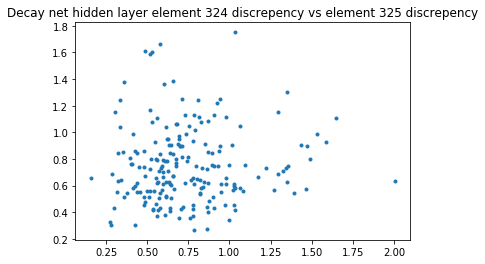

In [226]:
plt.plot(d_discrepency[:,324] / v1_mean_FF, d_discrepency[:,325] / v1_mean_FF, '.');
plt.title('Decay net hidden layer element 324 discrepency vs element 325 discrepency')

Text(0.5, 1.0, 'Decay net hidden layer element 324 discrepency vs element 325 discrepency')

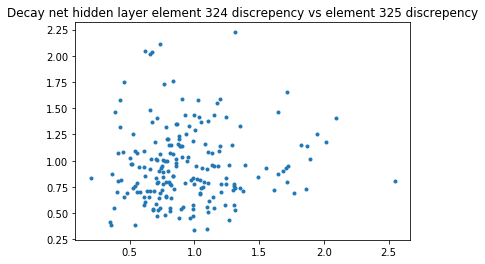

In [224]:
plt.plot(d_discrepency[:,324] / v1_mean_FB, d_discrepency[:,325] / v1_mean_FB, '.');
plt.title('Decay net hidden layer element 324 discrepency vs element 325 discrepency')

Text(0.5, 1.0, 'No decay net hidden layer element 324 discrepency vs element 325 discrepency')

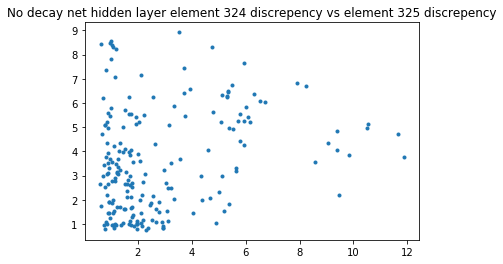

In [228]:
plt.plot(nd_discrepency[:,324] / v1_mean_FF, nd_discrepency[:,325] / v1_mean_FF, '.');
plt.title('No decay net hidden layer element 324 discrepency vs element 325 discrepency')

Text(0.5, 1.0, 'No decay net hidden layer element 324 discrepency vs element 325 discrepency')

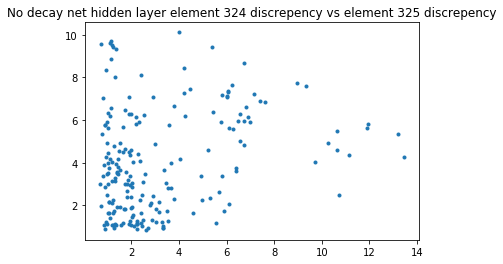

In [225]:
plt.plot(nd_discrepency[:,324] / v2_mean_FB, nd_discrepency[:,325] / v2_mean_FB, '.');
plt.title('No decay net hidden layer element 324 discrepency vs element 325 discrepency')

In [ ]:
c = 0
idx = 4
net_nodecay[idx].Generate(5., train[1][train[0][:,c]==1], dt=0.001)
nd_v1_FF = deepcopy(net_nodecay[idx].layers[1].v)

In [ ]:
net_decay[idx].Generate(5., train[1][train[0][:,c]==1], dt=0.001)
d_v1_FF = deepcopy(net_decay[idx].layers[1].v)

In [ ]:
net_nodecay[idx].Reset()
net_nodecay[idx].SetBidirectional()
net_nodecay[idx].layers[0].SetFF()
net_nodecay[idx].layers[-1].SetFF()
#net_nodecay[0].Predict(5., train[0][train[0][:,c]==1], dt=0.001);
net_nodecay[idx].Predict(5., torch.tensor(B[c]).float().to(device), dt=0.001);
nd_v1_FB = deepcopy(net_nodecay[idx].layers[1].v)

In [ ]:
net_decay[idx].Reset()
net_decay[idx].SetBidirectional()
net_decay[idx].layers[0].SetFF()
net_decay[idx].layers[-1].SetFF()
net_decay[idx].Predict(5., torch.tensor(B[c]).float().to(device), dt=0.001);
d_v1_FB = deepcopy(net_decay[idx].layers[1].v)

In [ ]:
np.mean(np.abs(nd_v1_FF - nd_v1_FB).numpy(), axis=0)

In [ ]:
np.mean(np.abs(d_v1_FF - d_v1_FB).numpy(), axis=0)

In [ ]:
net = net_nodecay[1]
net.Reset()
net.layers[0].Probe(True)
net.Generate(5., train[1][0], dt=0.001)
plt.plot(net.t_history, net.layers[0].v_history);

# Older Stuff

In [ ]:
# Slow Learn
net0.Reset()
net0.learning_tau = 0.8
# tanh: Wdecay 0.07, vdecay 0.01
# logistic: Wdecay 0.01, vdecay 0.001
net0.SetWeightDecay(0.0) # 0.05 too high
net0.SetvDecay(0.0)
net0.Learn(train[1], train[0], T=5., dt=0.002, epochs=10, batch_size=40)

In [ ]:
# Slow Learn
net1.Reset()
net1.learning_tau = 0.8
# tanh: Wdecay 0.07, vdecay 0.01
# logistic: Wdecay 0.01, vdecay 0.001
net1.SetWeightDecay(0.05) # 0.05 too high
net1.SetvDecay(0.05)
net1.Learn(train[1], train[0], T=5., dt=0.002, epochs=10, batch_size=40)

In [ ]:
# = FASTLEARN =
net.Reset()
net.l_rate = 0.0001
net.SetWeightDecay(0.0) # 0.05 too high
net.SetvDecay(0.00)
net.layers[0].SetFF()
net.layers[-1].SetBidirectional()
net.FastLearn(train[1], train[0], test=test, T=50, epochs=5, batch_size=20, freeze=1000)

In [ ]:
plt.plot(net.test_error_history);

In [ ]:
net0.Save('jo_data/MNIST50K_W0v0_tanh_10e.npy')

In [ ]:
net1.Save('jo_data/MNIST50K_W05v01_tanh_10e.npy')

In [ ]:
net0 = NN.NeuralNetwork()
net0.Load('jo_data/MNIST50K_W0v0_tanh_10e.npy')

In [ ]:
net1 = NN.NeuralNetwork()
net1.Load('jo_data/MNIST50K_W05v01_tanh_10e.npy')

In [ ]:
# FAST METHOD: Training Accuracy
correct = 0
z = net0.BackprojectExpectation(train[0])
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z,1)
t_classes = np.argmax(train[1], 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('asymmetric weights test set accuracy: {rate}'.format(rate=(correct / len(train[0]))))

In [ ]:
# FAST METHOD: Test Accuracy
correct = 0
z = net0.BackprojectExpectation(test[0])
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z,1)
t_classes = np.argmax(test[1], 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('asymmetric weights test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

In [ ]:
# FAST METHOD: Training Accuracy
correct = 0
z = net1.BackprojectExpectation(train[0])
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z,1)
t_classes = np.argmax(train[1], 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('asymmetric weights test set accuracy: {rate}'.format(rate=(correct / len(train[0]))))

In [ ]:
# FAST METHOD: Test Accuracy
correct = 0
z = net1.BackprojectExpectation(test[0])
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z,1)
t_classes = np.argmax(test[1], 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('asymmetric weights test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

In [ ]:
# CONTINUOUS-TIME METHOD: Test Accuracy
net0.Reset()
correct = 0
#net.SetvDecay(0.001)
#z = net.BackprojectExpectation(train[0])
z = net0.Generate(5., test[0], dt=0.002)
y_classes = np.argmax(z,1)
t_classes = np.argmax(test[1], 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('asymmetric weights test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

In [ ]:
# CONTINUOUS-TIME METHOD: Test Accuracy
net1.Reset()
correct = 0
net1.SetvDecay(0.001)
#z = net.BackprojectExpectation(train[0])
z = net1.Generate(5., test[0], dt=0.002)
y_classes = np.argmax(z,1)
t_classes = np.argmax(test[1], 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('asymmetric weights test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

In [ ]:
# CONTINUOUS-TIME METHOD: Training Accuracy
net1.Reset()
correct = 0
#net.SetvDecay(0.001)
#z = net.BackprojectExpectation(train[0])
z = net1.Generate(6., test[0], dt=0.002)
y_classes = np.argmax(z,1)
t_classes = np.argmax(train[1], 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('asymmetric weights test set accuracy: {rate}'.format(rate=(correct / len(train[0]))))

In [ ]:
torch.max(net.layers[3].e)

In [ ]:
net0.Reset()
# Continuous-time version
net0.SetvDecay(0.0)
net0.layers[0].SetFF()
net0.layers[-1].SetFF()
z0 = net0.Predict(6., train[1][idx], dt=0.002)
net1.Reset()
# Continuous-time version
net1.SetvDecay(0.001)
net1.layers[0].SetFF()
net1.layers[-1].SetFF()
z1 = net1.Predict(6., train[1][idx], dt=0.002)
plt.figure(figsize=[18,6])
for n in range(10):
    zz0 = z0[n]
    zz1 = z1[n]
    plt.subplot(3,10,n+1); DrawDigit(train[0][idx[n]])
    plt.subplot(3,10,n+11); DrawDigit(zz0)
    plt.subplot(3,10,n+21); DrawDigit(zz1)
plt.savefig('jo_data/digits_50K_tanh_10e.jpg', dpi=300, format='jpg')

In [ ]:
net0.Reset()
# Continuous-time version
net0.SetvDecay(0.0)
net0.layers[0].SetFF()
net0.layers[-1].SetFF()
z = net0.Predict(6., train[1][idx], dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(train[0][idx[n]])
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [ ]:
net1.Reset()
# Continuous-time version
net1.SetvDecay(0.001)
net1.layers[0].SetFF()
net1.layers[-1].SetFF()
z = net1.Predict(6., train[1][idx], dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(train[0][idx[n]])
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [ ]:
plt.plot(z[0])

In [ ]:
plt.plot(train[0][0])

In [ ]:
torch.max(z[0])

In [ ]:
torch.max(train[0])

In [ ]:
net.Reset()
# Continuous-time version
net.SetvDecay(0.005)
net.layers[0].SetFF()
net.layers[-1].SetFF()
z = net.Predict(6., train[1][:10], dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(train[0][n])
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [ ]:
net.Reset()
# Continuous-time version
net.SetvDecay(0.01)
net.layers[0].SetFF()
net.layers[-1].SetFF()
idx = [1, 3, 25, 7, 58,145, 62, 79, 41, 57]  # pick one of each digit class
z = net.Predict(6., train[1][idx], dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(train[0][idx[n]])
    plt.subplot(2,10,n+11); DrawDigit(zz)
raw = deepcopy(z)

In [ ]:
net.Reset()
# Continuous-time version
net.SetvDecay(0.001)
net.layers[0].SetFF()
net.layers[-1].SetFF()
idx = [1, 3, 25, 7, 58,145, 62, 79, 41, 57]  # pick one of each digit class
z = net.Predict(6., train[1][idx], dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(train[0][idx[n]])
    plt.subplot(2,10,n+11); DrawDigit(zz)
raw = deepcopy(z)

**Observations**

- The top-layer errors are all basically the same, except with different means.
- The raw reconstructions (`raw`) have means very close to zero.
- The inpainted recons (`inpaint`) have means close to the originals.

## Masked generation

In [ ]:
img_mask = torch.zeros((28,28))
d = 6
h = int(28/2-d)
img_mask[h:h+2*d,h:h+2*d] = 1.
alpha_mask = torch.reshape(img_mask, (784,)).float().to(device)
DrawDigit(alpha_mask)

In [ ]:
net.Reset()
idx = [1, 3, 25, 7, 58,145, 62, 79, 41, 57]  # pick one of each digit class
idx2 = deepcopy(idx)
idx2.reverse()
net.layers[-1].SetExpectation(train[0][idx2])
# Continuous-time version
net.SetvDecay(0.001)
net.layers[0].SetFF()
net.layers[-1].alpha = alpha_mask
net.layers[-1].beta = 1. - alpha_mask
inpaint = net.Predict(10., train[1][idx], dt=0.002)
plt.figure(figsize=[18,6])
for n,zz in enumerate(inpaint):
    plt.subplot(3,10,n+1); DrawDigit(train[0][idx[n]])
    plt.subplot(3,10,n+11); DrawDigit(zz)
    plt.subplot(3,10,n+21); DrawDigit(raw[n])

## Average Digit

In [ ]:
x_sum = torch.zeros_like(train[0][:10])
for x,t in zip(train[0],train[1]):
    idx = np.argmax(t)
    x_sum[idx,:] += x

In [ ]:
plt.figure(figsize=[18,2])
for n,zz in enumerate(x_sum):
    plt.subplot(1,10,n+1); DrawDigit(zz)

In [ ]:
torch.mean(raw)

In [ ]:
torch.mean(inpaint)

In [ ]:
torch.mean(train[0])

### Do the recons and in-painted images yield the same class vector?

In [ ]:
recons = deepcopy()

## Reconstructing a Digit

In [ ]:
net2 = NN.NeuralNetwork()
net2.Load('digits_recon_jo.npy')

In [ ]:
net2.layers[-1].SetFF()
net2.Reset()
z = net2.Predict(5., train[1][8], dt=0.001)
plt.imshow(np.reshape(z, [28,28]), cmap='gray');

In [ ]:
p = 1
y = net.BackprojectExpectation(train[0][:10])
print(y)

In [ ]:
net.SetBidirectional()

In [ ]:
net.Infer(4., train[1][p], train[0][p])

In [ ]:
net.Reset()
# Continuous-time version
net.SetvDecay(0.001)
net.layers[0].SetFF()
net.layers[-1].SetFF()
z = net.Predict(5., train[1][:10], dt=0.005)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); plt.imshow(np.reshape(train[0][n], [28,28]), cmap='gray'); plt.axis('off');    
    plt.subplot(2,10,n+11); plt.imshow(np.reshape(zz, [28,28]), cmap='gray'); plt.axis('off');

In [ ]:
# Look at the hidden-layer representations
# (run the above frame first)
plt.figure(figsize=[15,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); plt.imshow(np.reshape(net.layers[1].v[n], (30,20)), cmap='gray'); plt.axis('off');
    plt.subplot(2,10,n+11); plt.imshow(np.reshape(net.layers[2].v[n], (30,20)), cmap='gray'); plt.axis('off');    

In [ ]:
net.Reset()
z = net.Predict(5., torch.tensor([0,0,0,0,0,1,0,0,1,0]).float().to(device)/2., dt=0.005)
DrawDigit(z); plt.axis('off');

In [ ]:
# Fast version
p = 1
z = net.FastPredict(train[1][p], T=150)
plt.imshow(np.reshape(z,[28, 28]), cmap='gray'); plt.axis('off');

In [ ]:
net.layers[-1].SetFF()
net.Reset()
z = net.Predict(5., train[1][8], dt=0.001)

plt.imshow(np.reshape(z, [28,28]), cmap='gray');

In [ ]:
yy = net.BackprojectExpectation(z)
print(yy)